<a href="https://colab.research.google.com/github/SoudeepGhoshal/TResNet/blob/main/GradAttn_TissueMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MedMNIST (TissueMNIST)

In [ ]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
# ==========================================
# Gradient Flow Pattern Analysis
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import torch.nn.functional as F

class GradientFlowAnalyzer:
    """
    Comprehensive gradient flow analysis for deep neural networks.
    Analyzes gradient magnitudes, vanishing/exploding gradients, and flow patterns.
    """

    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.gradient_data = defaultdict(list)
        self.layer_names = []
        self.hooks = []

        # Register hooks for gradient capture
        self._register_hooks()

    def _register_hooks(self):
        """Register backward hooks to capture gradients during backpropagation."""
        def create_hook(name):
            def hook_fn(module, grad_input, grad_output):
                if grad_output[0] is not None:
                    grad_norm = torch.norm(grad_output[0]).item()
                    grad_mean = torch.mean(torch.abs(grad_output[0])).item()
                    grad_std = torch.std(grad_output[0]).item()
                    grad_max = torch.max(torch.abs(grad_output[0])).item()

                    self.gradient_data[name].append({
                        'norm': grad_norm,
                        'mean_abs': grad_mean,
                        'std': grad_std,
                        'max_abs': grad_max
                    })
            return hook_fn

        # Register hooks for key layers
        layer_count = 0
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear, nn.TransformerEncoderLayer)):
                hook_name = f"{name}_{type(module).__name__}_{layer_count}"
                self.layer_names.append(hook_name)
                hook = module.register_backward_hook(create_hook(hook_name))
                self.hooks.append(hook)
                layer_count += 1

    def analyze_batch_gradients(self, data_loader, num_batches=10):
        """
        Analyze gradient flow patterns over multiple batches.

        Args:
            data_loader: DataLoader for the dataset
            num_batches: Number of batches to analyze

        Returns:
            dict: Comprehensive gradient flow analysis results
        """
        self.model.train()  # Enable gradient computation
        criterion = nn.CrossEntropyLoss()

        # Clear previous data
        self.gradient_data.clear()

        print(f"Analyzing gradient flow over {num_batches} batches...")

        batch_count = 0
        for images, labels in tqdm(data_loader, desc="Gradient Flow Analysis"):
            if batch_count >= num_batches:
                break

            images, labels = images.to(self.device), labels.to(self.device)

            # Forward pass
            self.model.zero_grad()
            outputs = self.model(images)
            loss = criterion(outputs, labels)

            # Backward pass (this triggers our hooks)
            loss.backward()

            batch_count += 1

        # Analyze collected gradient data
        return self._compute_gradient_statistics()

    def _compute_gradient_statistics(self):
        """Compute comprehensive statistics from collected gradient data."""
        results = {
            'layer_statistics': {},
            'vanishing_layers': [],
            'exploding_layers': [],
            'gradient_health_score': 0.0,
            'flow_patterns': {}
        }

        # Thresholds for vanishing/exploding gradients
        vanishing_threshold = 1e-6
        exploding_threshold = 10.0

        total_layers = len(self.layer_names)
        healthy_layers = 0

        for layer_name in self.layer_names:
            if layer_name in self.gradient_data:
                layer_grads = self.gradient_data[layer_name]

                # Calculate statistics
                norms = [g['norm'] for g in layer_grads]
                means = [g['mean_abs'] for g in layer_grads]
                stds = [g['std'] for g in layer_grads]
                maxs = [g['max_abs'] for g in layer_grads]

                layer_stats = {
                    'mean_norm': np.mean(norms),
                    'std_norm': np.std(norms),
                    'mean_gradient': np.mean(means),
                    'std_gradient': np.std(stds),
                    'max_gradient': np.mean(maxs),
                    'min_norm': np.min(norms),
                    'max_norm': np.max(norms),
                    'norm_ratio': np.max(norms) / (np.min(norms) + 1e-8)
                }

                results['layer_statistics'][layer_name] = layer_stats

                # Check for vanishing gradients
                if layer_stats['mean_norm'] < vanishing_threshold:
                    results['vanishing_layers'].append({
                        'layer': layer_name,
                        'mean_norm': layer_stats['mean_norm'],
                        'severity': 'high' if layer_stats['mean_norm'] < 1e-8 else 'medium'
                    })

                # Check for exploding gradients
                if layer_stats['mean_norm'] > exploding_threshold:
                    results['exploding_layers'].append({
                        'layer': layer_name,
                        'mean_norm': layer_stats['mean_norm'],
                        'severity': 'high' if layer_stats['mean_norm'] > 100 else 'medium'
                    })

                # Count healthy layers (gradients in reasonable range)
                if vanishing_threshold < layer_stats['mean_norm'] < exploding_threshold:
                    healthy_layers += 1

        # Calculate overall gradient health score
        results['gradient_health_score'] = healthy_layers / total_layers if total_layers > 0 else 0.0

        # Analyze flow patterns
        results['flow_patterns'] = self._analyze_flow_patterns()

        return results

    def _analyze_flow_patterns(self):
        """Analyze gradient flow patterns across layers."""
        patterns = {
            'gradient_decay_rate': [],
            'layer_contribution': {},
            'bottleneck_layers': [],
            'gradient_correlation': {}
        }

        # Calculate gradient decay rate (how gradients diminish through layers)
        layer_norms = []
        for layer_name in self.layer_names:
            if layer_name in self.gradient_data:
                mean_norm = np.mean([g['norm'] for g in self.gradient_data[layer_name]])
                layer_norms.append(mean_norm)

        if len(layer_norms) > 1:
            # Calculate decay rate between consecutive layers
            for i in range(len(layer_norms) - 1):
                if layer_norms[i+1] > 0:
                    decay_rate = layer_norms[i] / layer_norms[i+1]
                    patterns['gradient_decay_rate'].append(decay_rate)

        # Identify bottleneck layers (layers with significantly lower gradients)
        if layer_norms:
            mean_norm = np.mean(layer_norms)
            std_norm = np.std(layer_norms)
            threshold = mean_norm - 2 * std_norm

            for i, (layer_name, norm) in enumerate(zip(self.layer_names, layer_norms)):
                if norm < threshold and norm > 0:
                    patterns['bottleneck_layers'].append({
                        'layer': layer_name,
                        'norm': norm,
                        'position': i / len(self.layer_names)
                    })

        return patterns

    def plot_gradient_flow(self, save_path=None):
        """
        Create comprehensive visualizations of gradient flow patterns.

        Args:
            save_path: Optional path to save the plots
        """
        if not self.gradient_data:
            print("No gradient data available. Run analyze_batch_gradients first.")
            return

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Gradient Flow Analysis', fontsize=16, fontweight='bold')

        # 1. Gradient norms across layers
        layer_names = []
        mean_norms = []
        std_norms = []

        for layer_name in self.layer_names:
            if layer_name in self.gradient_data:
                norms = [g['norm'] for g in self.gradient_data[layer_name]]
                layer_names.append(layer_name.split('_')[0][:10])  # Shorten names
                mean_norms.append(np.mean(norms))
                std_norms.append(np.std(norms))

        axes[0, 0].bar(range(len(layer_names)), mean_norms, yerr=std_norms, capsize=3)
        axes[0, 0].set_xlabel('Layers')
        axes[0, 0].set_ylabel('Gradient Norm')
        axes[0, 0].set_title('Mean Gradient Norms Across Layers')
        axes[0, 0].set_xticks(range(len(layer_names)))
        axes[0, 0].set_xticklabels(layer_names, rotation=45, ha='right')
        axes[0, 0].set_yscale('log')

        # 2. Gradient distribution heatmap
        if len(self.layer_names) > 1:
            gradient_matrix = []
            for layer_name in self.layer_names[:10]:  # Limit to first 10 layers
                if layer_name in self.gradient_data:
                    norms = [g['norm'] for g in self.gradient_data[layer_name]]
                    gradient_matrix.append(norms[:20])  # Limit to first 20 batches

            if gradient_matrix:
                gradient_matrix = np.array(gradient_matrix)
                im = axes[0, 1].imshow(gradient_matrix, cmap='viridis', aspect='auto')
                axes[0, 1].set_xlabel('Batch')
                axes[0, 1].set_ylabel('Layer')
                axes[0, 1].set_title('Gradient Norm Evolution')
                plt.colorbar(im, ax=axes[0, 1])

        # 3. Gradient statistics distribution
        all_norms = []
        for layer_name in self.layer_names:
            if layer_name in self.gradient_data:
                norms = [g['norm'] for g in self.gradient_data[layer_name]]
                all_norms.extend(norms)

        if all_norms:
            axes[1, 0].hist(np.log10(np.array(all_norms) + 1e-10), bins=50, alpha=0.7)
            axes[1, 0].set_xlabel('Log10(Gradient Norm)')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].set_title('Distribution of Gradient Norms')
            axes[1, 0].axvline(np.log10(1e-6), color='red', linestyle='--', label='Vanishing threshold')
            axes[1, 0].axvline(np.log10(10), color='orange', linestyle='--', label='Exploding threshold')
            axes[1, 0].legend()

        # 4. Layer-wise gradient flow
        if len(mean_norms) > 1:
            axes[1, 1].plot(range(len(mean_norms)), mean_norms, 'b-o', label='Mean Norm')
            axes[1, 1].fill_between(range(len(mean_norms)),
                                  np.array(mean_norms) - np.array(std_norms),
                                  np.array(mean_norms) + np.array(std_norms),
                                  alpha=0.3)
            axes[1, 1].set_xlabel('Layer Depth')
            axes[1, 1].set_ylabel('Gradient Norm')
            axes[1, 1].set_title('Gradient Flow Through Network')
            axes[1, 1].set_yscale('log')
            axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Gradient flow plots saved to {save_path}")

        plt.show()

    def generate_report(self):
        """Generate a comprehensive text report of gradient flow analysis."""
        if not self.gradient_data:
            return "No gradient data available. Run analyze_batch_gradients first."

        results = self._compute_gradient_statistics()

        report = []
        report.append("\n--- Gradient Flow Analysis Report ---")

        # Overall health
        health_score = results['gradient_health_score']
        report.append(f"Overall Gradient Health Score: {health_score:.2%}")

        if health_score > 0.8:
            report.append("✅ Excellent gradient flow - most layers have healthy gradients")
        elif health_score > 0.6:
            report.append("⚠️  Good gradient flow - some layers may need attention")
        elif health_score > 0.4:
            report.append("⚠️  Moderate gradient flow issues detected")
        else:
            report.append("❌ Poor gradient flow - significant issues detected")

        # Vanishing gradients
        if results['vanishing_layers']:
            report.append(f"🔍 VANISHING GRADIENTS DETECTED ({len(results['vanishing_layers'])} layers):")
            for layer_info in results['vanishing_layers']:
                severity = layer_info['severity'].upper()
                report.append(f"  - {layer_info['layer']}: {layer_info['mean_norm']:.2e} [{severity}]")
        else:
            report.append("✅ No vanishing gradient issues detected")

        # Exploding gradients
        if results['exploding_layers']:
            report.append(f"💥 EXPLODING GRADIENTS DETECTED ({len(results['exploding_layers'])} layers):")
            for layer_info in results['exploding_layers']:
                severity = layer_info['severity'].upper()
                report.append(f"  - {layer_info['layer']}: {layer_info['mean_norm']:.2e} [{severity}]")
        else:
            report.append("✅ No exploding gradient issues detected")

        # Flow patterns
        patterns = results['flow_patterns']
        if patterns['bottleneck_layers']:
            report.append(f"🚪 BOTTLENECK LAYERS DETECTED ({len(patterns['bottleneck_layers'])}):")
            for bottleneck in patterns['bottleneck_layers']:
                pos_percent = bottleneck['position'] * 100
                report.append(f"  - {bottleneck['layer']}: norm={bottleneck['norm']:.2e} (at {pos_percent:.1f}% depth)")

        # Gradient decay analysis
        if patterns['gradient_decay_rate']:
            mean_decay = np.mean(patterns['gradient_decay_rate'])
            report.append(f"📉 Average gradient decay rate: {mean_decay:.2f}")
            if mean_decay > 10:
                report.append("  ⚠️  High decay rate may indicate vanishing gradient issues")
            elif mean_decay < 0.1:
                report.append("  ⚠️  Low decay rate may indicate exploding gradient issues")

        # Layer statistics summary
        report.append(f"📊 LAYER STATISTICS SUMMARY:")
        report.append(f"  - Total layers analyzed: {len(results['layer_statistics'])}")

        if results['layer_statistics']:
            all_means = [stats['mean_norm'] for stats in results['layer_statistics'].values()]
            report.append(f"  - Average gradient norm: {np.mean(all_means):.2e}")
            report.append(f"  - Gradient norm range: {np.min(all_means):.2e} - {np.max(all_means):.2e}")
            report.append(f"  - Gradient norm std: {np.std(all_means):.2e}")

        return "\n".join(report)

    def cleanup(self):
        """Remove all registered hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        print("Gradient flow analyzer hooks cleaned up.")

## ResNet-18

Using device: cuda
Reproducibility seed: 42
Dataset: tissuemnist
Task: multi-class
Number of channels: 1
Number of classes: 8
Loading tissuemnist dataset...


100%|██████████| 125M/125M [00:08<00:00, 14.7MB/s]


Dataset splits - Train: 165466, Val: 23640, Test: 47280

--- Starting Training ---


Epoch 1/100 | Time: 160.70s | Train Loss: 1.1916, Train Acc: 55.60% | Val Loss: 1.2253, Val Acc: 55.77%

Model saved to ./best_model.pth


Epoch 2/100 | Time: 142.86s | Train Loss: 1.0581, Train Acc: 60.93% | Val Loss: 1.0597, Val Acc: 60.96%

Model saved to ./best_model.pth


Epoch 3/100 | Time: 142.28s | Train Loss: 1.0069, Train Acc: 62.78% | Val Loss: 1.0654, Val Acc: 60.77%


Epoch 4/100 | Time: 142.42s | Train Loss: 0.9772, Train Acc: 64.00% | Val Loss: 0.9683, Val Acc: 64.40%

Model saved to ./best_model.pth


Epoch 5/100 | Time: 141.21s | Train Loss: 0.9553, Train Acc: 64.86% | Val Loss: 0.9897, Val Acc: 63.35%


Epoch 6/100 | Time: 141.32s | Train Loss: 0.9359, Train Acc: 65.56% | Val Loss: 1.0389, Val Acc: 61.75%


Epoch 7/100 | Time: 143.08s | Train Loss: 0.9217, Train Acc: 66.10% | Val Loss: 1.0905, Val Acc: 59.41%

Reducing learning rate from 1.00e-03 to 2.00e-04


Epoch 8/100 | Time: 143.20s | Train Loss: 0.8469, Train Acc: 68.94% | Val Loss: 0.8566, Val Acc: 68.82%

Model saved to ./best_model.pth


Epoch 9/100 | Time: 143.07s | Train Loss: 0.8236, Train Acc: 69.91% | Val Loss: 0.8681, Val Acc: 68.26%


Epoch 10/100 | Time: 141.86s | Train Loss: 0.8095, Train Acc: 70.36% | Val Loss: 0.8455, Val Acc: 69.10%

Model saved to ./best_model.pth


Epoch 11/100 | Time: 142.77s | Train Loss: 0.7972, Train Acc: 70.91% | Val Loss: 0.8388, Val Acc: 69.42%

Model saved to ./best_model.pth


Epoch 12/100 | Time: 140.83s | Train Loss: 0.7880, Train Acc: 71.28% | Val Loss: 0.8687, Val Acc: 68.13%


Epoch 13/100 | Time: 141.69s | Train Loss: 0.7767, Train Acc: 71.68% | Val Loss: 0.8371, Val Acc: 69.60%

Model saved to ./best_model.pth


Epoch 14/100 | Time: 143.24s | Train Loss: 0.7656, Train Acc: 72.06% | Val Loss: 0.8416, Val Acc: 69.51%


Epoch 15/100 | Time: 142.63s | Train Loss: 0.7573, Train Acc: 72.38% | Val Loss: 0.8416, Val Acc: 69.70%

Model saved to ./best_model.pth


Epoch 16/100 | Time: 142.03s | Train Loss: 0.7458, Train Acc: 72.75% | Val Loss: 0.8877, Val Acc: 68.40%


Epoch 17/100 | Time: 141.23s | Train Loss: 0.7338, Train Acc: 73.17% | Val Loss: 0.8796, Val Acc: 68.79%


Epoch 18/100 | Time: 139.37s | Train Loss: 0.7223, Train Acc: 73.58% | Val Loss: 0.8495, Val Acc: 69.56%

Reducing learning rate from 2.00e-04 to 4.00e-05


Epoch 19/100 | Time: 138.83s | Train Loss: 0.6771, Train Acc: 75.39% | Val Loss: 0.8440, Val Acc: 70.00%

Model saved to ./best_model.pth


Epoch 20/100 | Time: 139.00s | Train Loss: 0.6602, Train Acc: 76.01% | Val Loss: 0.8543, Val Acc: 69.98%


Epoch 21/100 | Time: 139.73s | Train Loss: 0.6530, Train Acc: 76.23% | Val Loss: 0.8577, Val Acc: 69.82%


Epoch 22/100 | Time: 138.41s | Train Loss: 0.6429, Train Acc: 76.70% | Val Loss: 0.8608, Val Acc: 69.90%

Reducing learning rate from 4.00e-05 to 8.00e-06


Epoch 23/100 | Time: 139.56s | Train Loss: 0.6287, Train Acc: 77.25% | Val Loss: 0.8631, Val Acc: 69.86%


Epoch 24/100 | Time: 139.48s | Train Loss: 0.6250, Train Acc: 77.32% | Val Loss: 0.8646, Val Acc: 69.89%


Epoch 25/100 | Time: 140.32s | Train Loss: 0.6232, Train Acc: 77.42% | Val Loss: 0.8687, Val Acc: 69.75%

Reducing learning rate from 8.00e-06 to 1.60e-06


Epoch 26/100 | Time: 140.38s | Train Loss: 0.6191, Train Acc: 77.54% | Val Loss: 0.8675, Val Acc: 69.79%

Early stopping at epoch 26
Restored model weights from the end of the best epoch: 19
--- Training Finished ---

--- Starting Comprehensive Evaluation on Test Set ---


Evaluating: 100%|██████████| 370/370 [00:16<00:00, 21.96it/s]



--- Starting Gradient Flow Analysis ---
Analyzing gradient flow over 20 batches...


Gradient Flow Analysis:   0%|          | 0/370 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Gradient Flow Analysis:   5%|▌         | 20/370 [00:01<00:31, 11.27it/s]


Gradient flow plots saved to gradient_flow_analysis.png


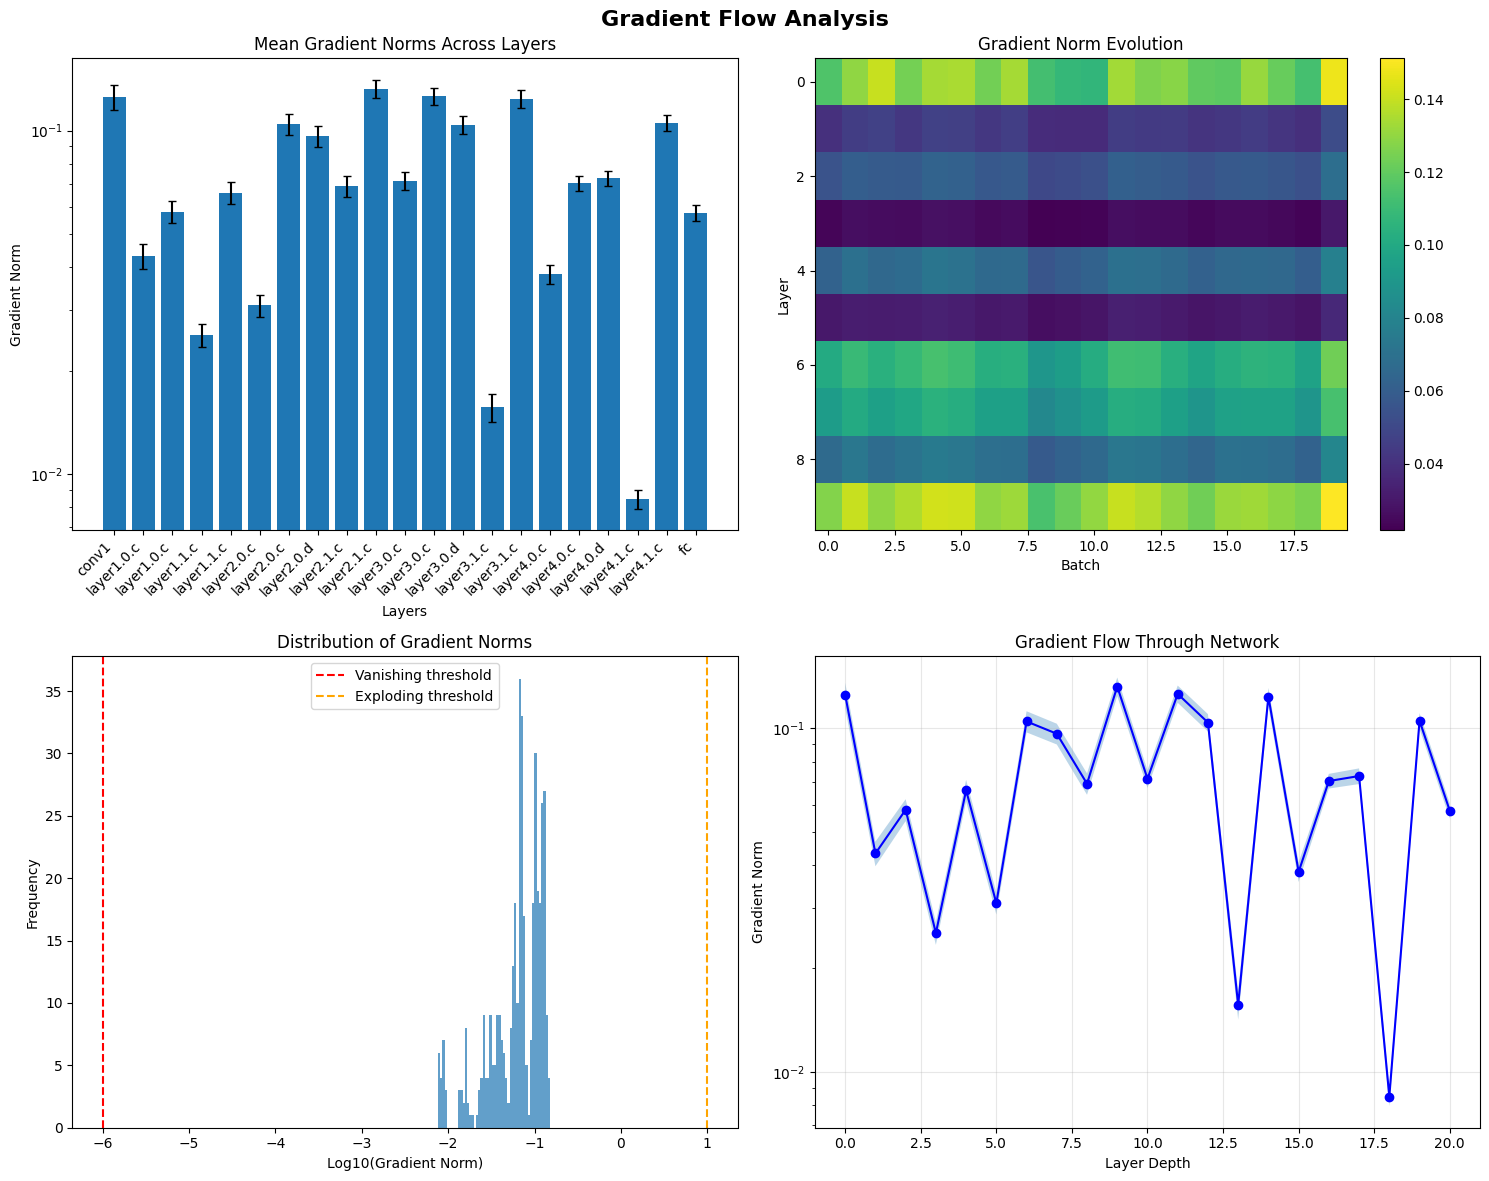

Gradient flow analyzer hooks cleaned up.

Total Training Time: 1h 1m 32s

--- Top-K Accuracy Results ---
Top-1 Accuracy: 69.88%
Top-3 Accuracy: 93.83%
Top-5 Accuracy: 98.55%

--- Additional Performance Metrics ---
Macro Average Precision: 0.6306
Macro Average Recall: 0.6091
Macro Average F1-Score: 0.6167
Weighted Average Precision: 0.6947
Weighted Average Recall: 0.6988
Weighted Average F1-Score: 0.6948

--- Model Confidence & Calibration Metrics ---
Average Prediction Confidence: 0.7657
Confidence Standard Deviation: 0.2044
Average Prediction Entropy: 0.6400
Expected Calibration Error: 0.0669

Final Test Loss: 0.8633

--- Model Parameters ---
  Total: 11.18M (11,180,616)
  Trainable: 11.18M (11,180,616)
  Non-trainable: 0 (0)
  Memory (float32): ~42.7 MB

--- Gradient Flow Analysis Report ---
Overall Gradient Health Score: 100.00%
✅ Excellent gradient flow - most layers have healthy gradients
✅ No vanishing gradient issues detected
✅ No exploding gradient issues detected
📉 Average gra

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import os
import time
import requests
import zipfile
import shutil
from tqdm import tqdm
import time
import sys
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import medmnist
from medmnist import INFO

# --- Configuration Parameters ---
CONFIG = {
    "batch_size": 128,
    "num_epochs": 100,
    "learning_rate": 0.001,
    "weight_decay": 1e-4,
    "split_seed": 42, # Seed for creating reproducible dataset splits
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_path": "./best_model.pth",  # Added checkpoint path
}

# ==========================================
# Callback Classes
# ==========================================

class Callback:
    """Base callback class"""
    def on_epoch_end(self, epoch, logs=None):
        pass

    def on_training_end(self):
        pass

class ReduceLROnPlateau(Callback):
    """Reduce learning rate when a metric has stopped improving"""
    def __init__(self, optimizer, monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-7, verbose=1):
        self.optimizer = optimizer
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.mode = 'min' if 'loss' in monitor else 'max'

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return

        current = logs.get(self.monitor)
        if current is None:
            return

        if self.best is None:
            self.best = current
            return

        if self.mode == 'min':
            improved = current < self.best
        else:
            improved = current > self.best

        if improved:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = self.optimizer.param_groups[0]['lr']
                new_lr = max(old_lr * self.factor, self.min_lr)
                if new_lr != old_lr:
                    self.optimizer.param_groups[0]['lr'] = new_lr
                    if self.verbose:
                        print(f"\nReducing learning rate from {old_lr:.2e} to {new_lr:.2e}")
                    self.wait = 0

class EarlyStopping(Callback):
    """Stop training when a monitored metric has stopped improving"""
    def __init__(self, monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1):
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.best_weights = None
        self.mode = 'min' if 'loss' in monitor else 'max'
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None, model=None):
        if logs is None:
            return False

        current = logs.get(self.monitor)
        if current is None:
            return False

        if self.best is None:
            self.best = current
            if model is not None and self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
            return False

        if self.mode == 'min':
            improved = current < self.best
        else:
            improved = current > self.best

        if improved:
            self.best = current
            self.wait = 0
            if model is not None and self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if self.verbose:
                    print(f"\nEarly stopping at epoch {epoch + 1}")
                return True
        return False

    def on_training_end(self, model=None):
        if self.stopped_epoch > 0 and self.verbose:
            print(f"Restored model weights from the end of the best epoch: {self.stopped_epoch + 1 - self.patience}")
        if model is not None and self.restore_best_weights and self.best_weights is not None:
            model.load_state_dict(self.best_weights)

class ModelCheckpoint(Callback):
    """Save the model after every epoch"""
    def __init__(self, filepath, save_best_only=True, monitor='val_accuracy', verbose=1):
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.monitor = monitor
        self.verbose = verbose
        self.best = None
        self.mode = 'min' if 'loss' in monitor else 'max'

    def on_epoch_end(self, epoch, logs=None, model=None):
        if logs is None or model is None:
            return

        current = logs.get(self.monitor)
        if current is None:
            return

        if not self.save_best_only:
            filepath = self.filepath.replace('.pth', f'_epoch_{epoch + 1}.pth')
            torch.save(model.state_dict(), filepath)
            if self.verbose:
                print(f"\nModel saved to {filepath}")
            return

        if self.best is None:
            self.best = current
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(f"\nModel saved to {self.filepath}")
            return

        if self.mode == 'min':
            improved = current < self.best
        else:
            improved = current > self.best

        if improved:
            self.best = current
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(f"\nModel saved to {self.filepath}")

# ==========================================
# Data Preprocessing
# ==========================================

def get_dataloaders(config):
    """Downloads, prepares MedMNIST data with augmentation, returning DataLoaders."""

    # MedMNIST dataset configuration
    dataset_name = "tissuemnist"  # Options: pathmnist, chestmnist, dermamnist, octmnist, pneumoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist

    # Get dataset info
    info = INFO[dataset_name]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    print(f"Dataset: {dataset_name}")
    print(f"Task: {task}")
    print(f"Number of channels: {n_channels}")
    print(f"Number of classes: {n_classes}")

    # Update config with dataset info
    config["num_classes"] = n_classes

    # Get the dataset class
    DataClass = getattr(medmnist, info['python_class'])

    # Define transforms
    # Training transforms (with augmentation)
    train_transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize to match original Tiny ImageNet size
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        # Convert grayscale to RGB if needed
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation/Test transforms (no augmentation)
    val_test_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    print(f"Loading {dataset_name} dataset...")

    # Load datasets - MedMNIST provides predefined train/val/test splits
    train_dataset = DataClass(
        split='train',
        transform=train_transform,
        download=True,  # Will download if not present
        as_rgb=False    # We handle RGB conversion in transforms
    )

    val_dataset = DataClass(
        split='val',
        transform=val_test_transform,
        download=True,
        as_rgb=False
    )

    test_dataset = DataClass(
        split='test',
        transform=val_test_transform,
        download=True,
        as_rgb=False
    )

    print(f"Dataset splits - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Handle different task types
    if task == 'multi-label, binary-class':
        def collate_fn(batch):
            images = torch.stack([item[0] for item in batch])
            # Fix: Convert to numpy array first, then to tensor
            labels_np = np.array([item[1] for item in batch])
            labels = torch.tensor(labels_np, dtype=torch.float32).squeeze()
            return images, labels
    else:
        def collate_fn(batch):
            images = torch.stack([item[0] for item in batch])
            # Fix: Convert to numpy array first, then to tensor
            labels_np = np.array([item[1] for item in batch])
            labels = torch.tensor(labels_np, dtype=torch.long).squeeze()
            return images, labels

    # Set worker init function for reproducible DataLoader behavior
    def worker_init_fn(worker_id):
        np.random.seed(config["split_seed"] + worker_id)

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config["batch_size"],
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        collate_fn=collate_fn,
        generator=torch.Generator().manual_seed(config["split_seed"])
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        collate_fn=collate_fn
    )

    return train_loader, val_loader, test_loader

# ==========================================
# Model Architecture and Training
# ==========================================

class ResidualBlock(nn.Module):
    """A residual block, the fundamental building block of ResNet."""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut path (for matching dimensions)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    """A modular ResNet implementation."""
    def __init__(self, block, layers, num_classes=200):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def ResNet18(num_classes=200):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes)

def evaluate_model(model, data_loader, criterion, device):
    """Evaluates the model on a given dataset."""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_and_validate(model, train_loader, val_loader, config):
    """Main training loop with callbacks."""
    device = config["device"]
    model.to(device)

    # Set seeds for reproducible training
    torch.manual_seed(config["split_seed"])
    np.random.seed(config["split_seed"])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(config["split_seed"])
        torch.cuda.manual_seed_all(config["split_seed"])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    # Initialize callbacks
    callbacks = [
        ReduceLROnPlateau(
            optimizer=optimizer,
            monitor='val_accuracy',
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=config["checkpoint_path"],
            save_best_only=True,
            monitor='val_accuracy',
            verbose=1
        )
    ]

    print("\n--- Starting Training ---")
    early_stop = False

    for epoch in range(config["num_epochs"]):
        if early_stop:
            break

        model.train()
        start_time = time.time()
        running_loss, train_correct, train_total = 0.0, 0, 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Train]", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / train_total
        train_acc = 100 * train_correct / train_total
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{config['num_epochs']} | Time: {time.time() - start_time:.2f}s | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Prepare logs for callbacks
        logs = {
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
        }

        # Execute callbacks
        for callback in callbacks:
            if isinstance(callback, EarlyStopping):
                if callback.on_epoch_end(epoch, logs, model):
                    early_stop = True
                    break
            elif isinstance(callback, ModelCheckpoint):
                callback.on_epoch_end(epoch, logs, model)
            else:
                callback.on_epoch_end(epoch, logs)

    # Execute callback cleanup
    for callback in callbacks:
        if isinstance(callback, EarlyStopping):
            callback.on_training_end(model)
        else:
            callback.on_training_end()

    print("--- Training Finished ---\n")
    return model

# ==========================================
# Evaluation
# ==========================================

def calculate_top_k_accuracy(outputs, labels, k_values=[1, 3, 5]):
    """Calculate top-k accuracy for given k values."""
    batch_size = labels.size(0)
    _, pred = outputs.topk(max(k_values), 1, True, True)
    pred = pred.t()
    correct = pred.eq(labels.view(1, -1).expand_as(pred))

    top_k_accuracies = {}
    for k in k_values:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        top_k_accuracies[k] = correct_k.item() / batch_size

    return top_k_accuracies

def calculate_entropy(probs):
    """Calculate entropy of probability distributions."""
    # Add small epsilon to avoid log(0)
    epsilon = 1e-8
    probs = probs + epsilon
    entropy = -torch.sum(probs * torch.log(probs), dim=1)
    return entropy

def calculate_ece(confidences, accuracies, n_bins=10):
    """Calculate Expected Calibration Error."""
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower.item()) & (confidences <= bin_upper.item())
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece.item()

def comprehensive_evaluation(model, test_loader, criterion, device):
    """Comprehensive evaluation with all requested metrics."""
    model.eval()

    all_predictions = []
    all_labels = []
    all_confidences = []
    all_entropies = []
    all_top_k_results = {1: [], 3: [], 5: []}
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Convert outputs to probabilities
            probs = torch.softmax(outputs, dim=1)

            # Get predictions and confidences
            confidences, predictions = torch.max(probs, dim=1)

            # Calculate entropy
            entropies = calculate_entropy(probs)

            # Calculate top-k accuracies
            top_k_accs = calculate_top_k_accuracy(outputs, labels, [1, 3, 5])

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
            all_entropies.extend(entropies.cpu().numpy())

            for k in [1, 3, 5]:
                all_top_k_results[k].extend([top_k_accs[k]] * labels.size(0))

            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_confidences = np.array(all_confidences)
    all_entropies = np.array(all_entropies)

    # Calculate basic metrics
    avg_loss = total_loss / total_samples

    # Calculate top-k accuracies
    top1 = np.mean([pred == label for pred, label in zip(all_predictions, all_labels)])
    top3 = np.mean(all_top_k_results[3])
    top5 = np.mean(all_top_k_results[5])

    # Calculate precision, recall, f1-score
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='macro', zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted', zero_division=0
    )

    # Calculate confidence and calibration metrics
    avg_confidence = np.mean(all_confidences)
    std_confidence = np.std(all_confidences)
    avg_entropy = np.mean(all_entropies)

    # Calculate ECE
    accuracies = (all_predictions == all_labels).astype(float)
    ece = calculate_ece(torch.tensor(all_confidences), torch.tensor(accuracies))

    return {
        'test_loss': avg_loss,
        'top1': top1,
        'top3': top3,
        'top5': top5,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'avg_confidence': avg_confidence,
        'std_confidence': std_confidence,
        'avg_entropy': avg_entropy,
        'ece': ece
    }

def analyze_gradient_flow(model, data_loader, device, num_batches=10, plot=True, save_plot_path=None):
    """
    Convenience function to perform complete gradient flow analysis.

    Args:
        model: PyTorch model to analyze
        data_loader: DataLoader for the dataset
        device: Device to run analysis on
        num_batches: Number of batches to analyze
        plot: Whether to generate plots
        save_plot_path: Path to save plots (optional)

    Returns:
        dict: Analysis results
        str: Text report
    """
    analyzer = GradientFlowAnalyzer(model, device)

    try:
        # Perform analysis
        results = analyzer.analyze_batch_gradients(data_loader, num_batches)

        # Generate report
        report = analyzer.generate_report()

        # Create plots if requested
        if plot:
            analyzer.plot_gradient_flow(save_plot_path)

        return results, report

    finally:
        # Always cleanup hooks
        analyzer.cleanup()

def print_model_parameters(model):
    """Print model parameter counts in a simple format."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable = total - trainable

    def format_num(num):
        if num >= 1e6:
            return f"{num/1e6:.2f}M"
        elif num >= 1e3:
            return f"{num/1e3:.2f}K"
        else:
            return str(num)

    print("\n--- Model Parameters ---")
    print(f"  Total: {format_num(total)} ({total:,})")
    print(f"  Trainable: {format_num(trainable)} ({trainable:,})")
    print(f"  Non-trainable: {format_num(non_trainable)} ({non_trainable:,})")
    print(f"  Memory (float32): ~{total * 4 / 1024**2:.1f} MB")

def print_training_time(start_time, end_time):
    """Print formatted training time."""
    def format_time(seconds):
        """Format seconds into human-readable time."""
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        seconds = int(seconds % 60)

        if hours > 0:
            return f"{hours}h {minutes}m {seconds}s"
        elif minutes > 0:
            return f"{minutes}m {seconds}s"
        else:
            return f"{seconds}s"

    total_time = end_time - start_time
    print(f"\nTotal Training Time: {format_time(total_time)}")

# ==========================================
# Main Execution
# ==========================================

if __name__ == '__main__':
    # Set global seeds for full reproducibility
    torch.manual_seed(CONFIG["split_seed"])
    np.random.seed(CONFIG["split_seed"])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(CONFIG["split_seed"])
        torch.cuda.manual_seed_all(CONFIG["split_seed"])
        # Ensure deterministic behavior on CUDA
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    print(f"Using device: {CONFIG['device']}")
    print(f"Reproducibility seed: {CONFIG['split_seed']}")

    # Get data loaders
    dataloaders = get_dataloaders(CONFIG)
    if dataloaders is None:
        print("Could not prepare data. Halting execution.", file=sys.stderr)
        sys.exit(1) # Exit if data preparation failed

    train_loader, val_loader, test_loader = dataloaders

    # Initialize and train model
    model = ResNet18(num_classes=CONFIG["num_classes"])
    training_start_time = time.time()
    trained_model = train_and_validate(model, train_loader, val_loader, CONFIG)
    training_end_time = time.time()

    # Comprehensive evaluation on the test set
    print("--- Starting Comprehensive Evaluation on Test Set ---")
    results = comprehensive_evaluation(trained_model, test_loader, nn.CrossEntropyLoss(), CONFIG["device"])

    # Perform gradient flow analysis
    print("\n--- Starting Gradient Flow Analysis ---")
    gradient_results, gradient_report = analyze_gradient_flow(
        model=model,
        data_loader=test_loader,
        device=CONFIG["device"],
        num_batches=20,  # Analyze 20 batches for comprehensive results
        plot=True,
        save_plot_path="gradient_flow_analysis.png"
    )

    # Print all requested metrics
    print_training_time(training_start_time, training_end_time)

    print("\n--- Top-K Accuracy Results ---")
    print(f"Top-1 Accuracy: {results['top1'] * 100:.2f}%")
    print(f"Top-3 Accuracy: {results['top3'] * 100:.2f}%")
    print(f"Top-5 Accuracy: {results['top5'] * 100:.2f}%")

    print("\n--- Additional Performance Metrics ---")
    print(f"Macro Average Precision: {results['precision_macro']:.4f}")
    print(f"Macro Average Recall: {results['recall_macro']:.4f}")
    print(f"Macro Average F1-Score: {results['f1_macro']:.4f}")
    print(f"Weighted Average Precision: {results['precision_weighted']:.4f}")
    print(f"Weighted Average Recall: {results['recall_weighted']:.4f}")
    print(f"Weighted Average F1-Score: {results['f1_weighted']:.4f}")

    print("\n--- Model Confidence & Calibration Metrics ---")
    print(f"Average Prediction Confidence: {results['avg_confidence']:.4f}")
    print(f"Confidence Standard Deviation: {results['std_confidence']:.4f}")
    print(f"Average Prediction Entropy: {results['avg_entropy']:.4f}")
    print(f"Expected Calibration Error: {results['ece']:.4f}")

    print(f"\nFinal Test Loss: {results['test_loss']:.4f}")

    print_model_parameters(model)

    print(gradient_report)
    print("=" * 60)

## Hybrid Transformer on ResNet-18 (No PE)

Using device: cuda
Reproducibility seed: 42
Dataset: tissuemnist
Task: multi-class
Number of channels: 1
Number of classes: 8
Loading tissuemnist dataset...


100%|██████████| 125M/125M [00:07<00:00, 16.1MB/s]


Dataset splits - Train: 165466, Val: 23640, Test: 47280

--- Starting Training ---


Epoch 1/100 | Time: 153.85s | Train Loss: 1.2420, Train Acc: 53.36% | Val Loss: 1.2369, Val Acc: 51.59%

Model saved to ./best_model.pth


Epoch 2/100 | Time: 154.30s | Train Loss: 1.0898, Train Acc: 59.64% | Val Loss: 1.5447, Val Acc: 50.41%


Epoch 3/100 | Time: 155.60s | Train Loss: 1.0280, Train Acc: 62.05% | Val Loss: 1.0529, Val Acc: 61.32%

Model saved to ./best_model.pth


Epoch 4/100 | Time: 156.92s | Train Loss: 0.9977, Train Acc: 63.14% | Val Loss: 1.0590, Val Acc: 61.67%

Model saved to ./best_model.pth


Epoch 5/100 | Time: 155.07s | Train Loss: 0.9764, Train Acc: 64.02% | Val Loss: 1.0937, Val Acc: 58.95%


Epoch 6/100 | Time: 155.92s | Train Loss: 0.9582, Train Acc: 64.70% | Val Loss: 1.0497, Val Acc: 62.71%

Model saved to ./best_model.pth


Epoch 7/100 | Time: 155.85s | Train Loss: 0.9471, Train Acc: 65.20% | Val Loss: 0.9833, Val Acc: 64.02%

Model saved to ./best_model.pth


Epoch 8/100 | Time: 153.22s | Train Loss: 0.9351, Train Acc: 65.60% | Val Loss: 1.0173, Val Acc: 62.65%


Epoch 9/100 | Time: 153.84s | Train Loss: 0.9274, Train Acc: 65.86% | Val Loss: 0.9414, Val Acc: 65.49%

Model saved to ./best_model.pth


Epoch 10/100 | Time: 153.21s | Train Loss: 0.9186, Train Acc: 66.17% | Val Loss: 0.9523, Val Acc: 64.97%


Epoch 11/100 | Time: 152.90s | Train Loss: 0.9126, Train Acc: 66.40% | Val Loss: 0.9188, Val Acc: 66.29%

Model saved to ./best_model.pth


Epoch 12/100 | Time: 152.75s | Train Loss: 0.9063, Train Acc: 66.83% | Val Loss: 0.9584, Val Acc: 64.74%


Epoch 13/100 | Time: 152.92s | Train Loss: 0.9022, Train Acc: 66.97% | Val Loss: 0.9214, Val Acc: 66.30%

Model saved to ./best_model.pth


Epoch 14/100 | Time: 153.07s | Train Loss: 0.8953, Train Acc: 67.27% | Val Loss: 0.9844, Val Acc: 63.13%


Epoch 15/100 | Time: 152.96s | Train Loss: 0.8940, Train Acc: 67.36% | Val Loss: 1.2242, Val Acc: 56.24%


Epoch 16/100 | Time: 152.35s | Train Loss: 0.8888, Train Acc: 67.41% | Val Loss: 0.9282, Val Acc: 65.56%

Reducing learning rate from 1.00e-03 to 2.00e-04


Epoch 17/100 | Time: 153.58s | Train Loss: 0.8302, Train Acc: 69.68% | Val Loss: 0.8617, Val Acc: 68.57%

Model saved to ./best_model.pth


Epoch 18/100 | Time: 151.15s | Train Loss: 0.8152, Train Acc: 70.32% | Val Loss: 0.8346, Val Acc: 69.99%

Model saved to ./best_model.pth


Epoch 19/100 | Time: 151.05s | Train Loss: 0.8093, Train Acc: 70.53% | Val Loss: 0.8631, Val Acc: 68.82%


Epoch 20/100 | Time: 153.40s | Train Loss: 0.8021, Train Acc: 70.89% | Val Loss: 0.8378, Val Acc: 69.88%


Epoch 21/100 | Time: 153.28s | Train Loss: 0.7977, Train Acc: 71.05% | Val Loss: 0.8317, Val Acc: 69.95%

Reducing learning rate from 2.00e-04 to 4.00e-05


Epoch 22/100 | Time: 152.76s | Train Loss: 0.7789, Train Acc: 71.69% | Val Loss: 0.8223, Val Acc: 70.30%

Model saved to ./best_model.pth


Epoch 23/100 | Time: 153.92s | Train Loss: 0.7750, Train Acc: 71.91% | Val Loss: 0.8266, Val Acc: 70.24%


Epoch 24/100 | Time: 152.96s | Train Loss: 0.7710, Train Acc: 72.00% | Val Loss: 0.8281, Val Acc: 70.16%


Epoch 25/100 | Time: 152.20s | Train Loss: 0.7696, Train Acc: 72.10% | Val Loss: 0.8241, Val Acc: 70.33%

Model saved to ./best_model.pth


Epoch 26/100 | Time: 150.96s | Train Loss: 0.7670, Train Acc: 72.22% | Val Loss: 0.8254, Val Acc: 70.34%

Model saved to ./best_model.pth


Epoch 27/100 | Time: 151.20s | Train Loss: 0.7664, Train Acc: 72.24% | Val Loss: 0.8236, Val Acc: 70.47%

Model saved to ./best_model.pth


Epoch 28/100 | Time: 150.62s | Train Loss: 0.7629, Train Acc: 72.42% | Val Loss: 0.8247, Val Acc: 70.40%


Epoch 29/100 | Time: 151.17s | Train Loss: 0.7641, Train Acc: 72.25% | Val Loss: 0.8230, Val Acc: 70.44%


Epoch 30/100 | Time: 150.90s | Train Loss: 0.7615, Train Acc: 72.38% | Val Loss: 0.8304, Val Acc: 69.98%

Reducing learning rate from 4.00e-05 to 8.00e-06


Epoch 31/100 | Time: 150.49s | Train Loss: 0.7566, Train Acc: 72.53% | Val Loss: 0.8281, Val Acc: 70.16%


Epoch 32/100 | Time: 152.65s | Train Loss: 0.7551, Train Acc: 72.73% | Val Loss: 0.8251, Val Acc: 70.44%


Epoch 33/100 | Time: 153.64s | Train Loss: 0.7561, Train Acc: 72.61% | Val Loss: 0.8251, Val Acc: 70.24%

Reducing learning rate from 8.00e-06 to 1.60e-06


Epoch 34/100 | Time: 152.73s | Train Loss: 0.7531, Train Acc: 72.72% | Val Loss: 0.8238, Val Acc: 70.45%

Early stopping at epoch 34
Restored model weights from the end of the best epoch: 27
--- Training Finished ---

--- Starting Comprehensive Evaluation on Test Set ---


Evaluating: 100%|██████████| 370/370 [00:18<00:00, 20.31it/s]



--- Starting Gradient Flow Analysis ---
Analyzing gradient flow over 20 batches...


Gradient Flow Analysis:   0%|          | 0/370 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Gradient Flow Analysis:   5%|▌         | 20/370 [00:02<00:44,  7.88it/s]


Gradient flow plots saved to gradient_flow_analysis.png


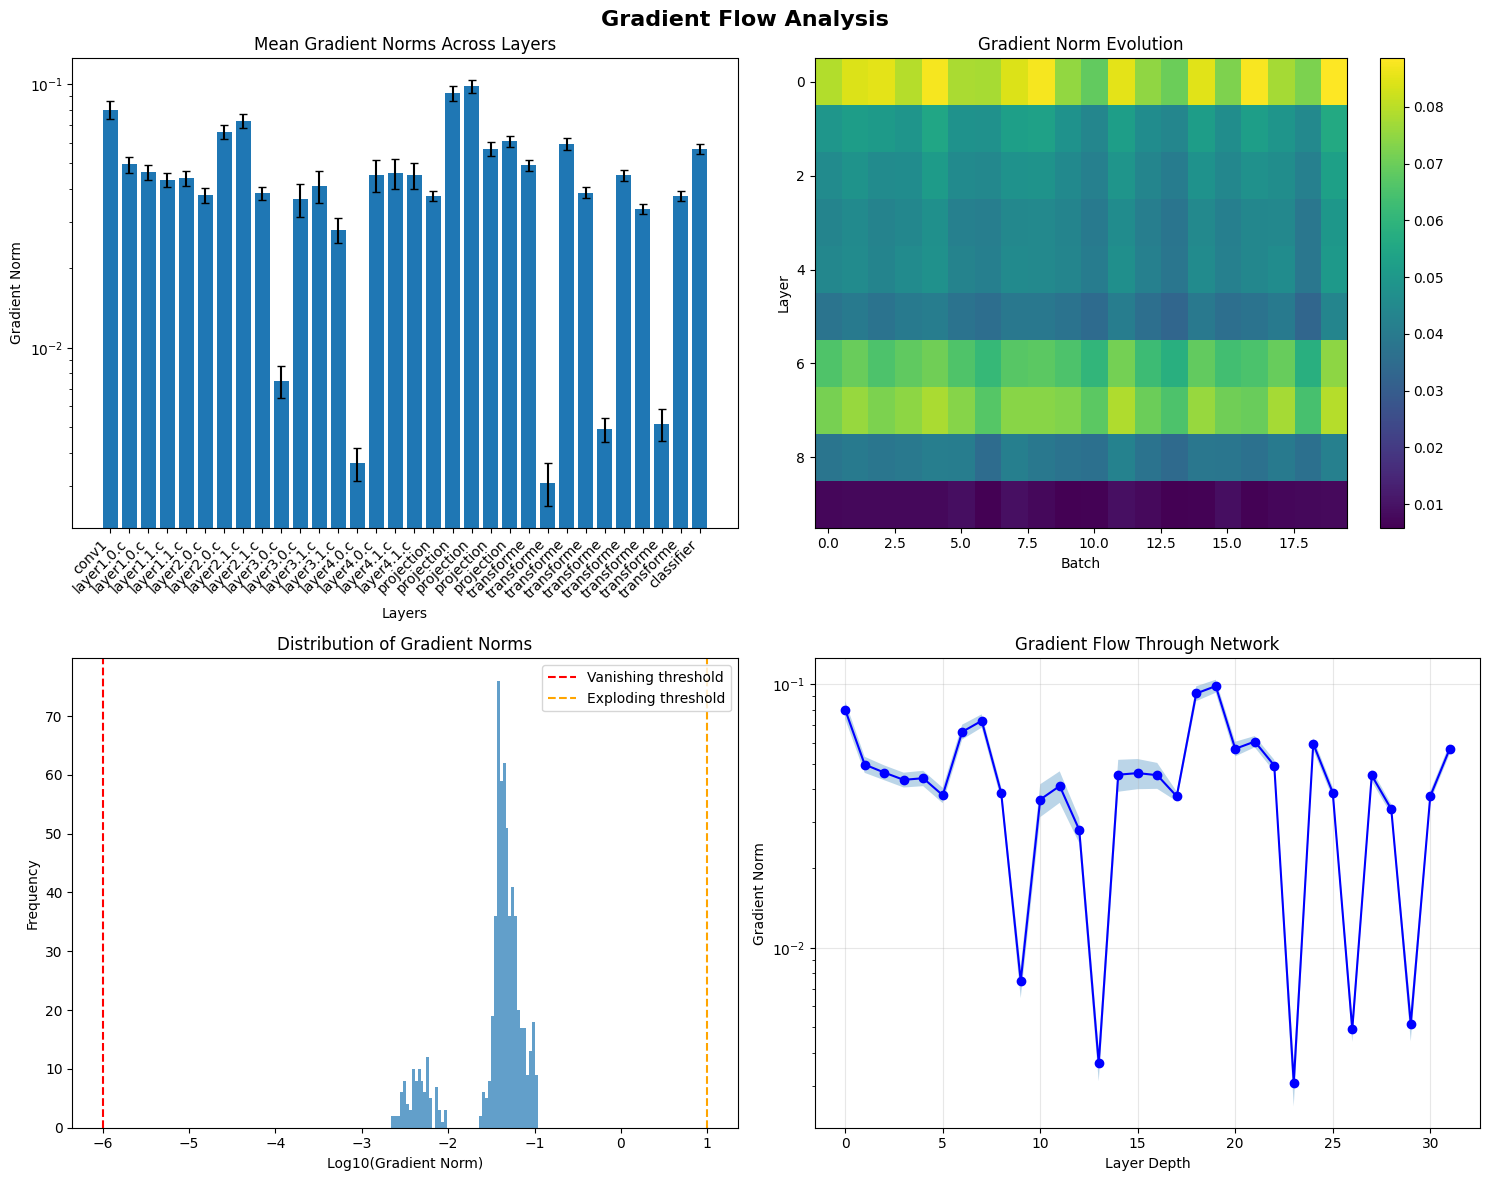

Gradient flow analyzer hooks cleaned up.

Total Training Time: 1h 26m 45s

--- Top-K Accuracy Results ---
Top-1 Accuracy: 70.69%
Top-3 Accuracy: 94.06%
Top-5 Accuracy: 98.63%

--- Additional Performance Metrics ---
Macro Average Precision: 0.6439
Macro Average Recall: 0.6216
Macro Average F1-Score: 0.6279
Weighted Average Precision: 0.7040
Weighted Average Recall: 0.7069
Weighted Average F1-Score: 0.7026

--- Model Confidence & Calibration Metrics ---
Average Prediction Confidence: 0.7379
Confidence Standard Deviation: 0.2072
Average Prediction Entropy: 0.7268
Expected Calibration Error: 0.0310

Final Test Loss: 0.8136

--- Model Parameters ---
  Total: 11.05M (11,049,422)
  Trainable: 11.05M (11,049,422)
  Non-trainable: 0 (0)
  Memory (float32): ~42.2 MB

--- Gradient Flow Analysis Report ---
Overall Gradient Health Score: 91.43%
✅ Excellent gradient flow - most layers have healthy gradients
✅ No vanishing gradient issues detected
✅ No exploding gradient issues detected
📉 Average gra

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import os
import time
import requests
import zipfile
import shutil
from tqdm import tqdm
import time
import sys
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import medmnist
from medmnist import INFO

# --- Configuration Parameters ---
CONFIG = {
    "batch_size": 128,
    "num_epochs": 100,
    "learning_rate": 0.001,
    "weight_decay": 1e-4,
    "split_seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_path": "./best_model.pth",
}

# --- Transformer Configuration ---
TRANSFORMER_CONFIG = {
    "embedding_dim": 32,
    "nhead": 16,
    "num_encoder_layers": 3,
    "dim_feedforward": 2,
    "dropout": 0.1,
}

# ==========================================
# Callback Classes
# ==========================================

class Callback:
    """Base callback class"""
    def on_epoch_end(self, epoch, logs=None):
        pass

    def on_training_end(self):
        pass

class ReduceLROnPlateau(Callback):
    """Reduce learning rate when a metric has stopped improving"""
    def __init__(self, optimizer, monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1):
        self.optimizer = optimizer
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.mode = 'min' if 'loss' in monitor else 'max'

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return

        current = logs.get(self.monitor)
        if current is None:
            return

        if self.best is None:
            self.best = current
            return

        if self.mode == 'min':
            improved = current < self.best
        else:
            improved = current > self.best

        if improved:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = self.optimizer.param_groups[0]['lr']
                new_lr = max(old_lr * self.factor, self.min_lr)
                if new_lr != old_lr:
                    self.optimizer.param_groups[0]['lr'] = new_lr
                    if self.verbose:
                        print(f"\nReducing learning rate from {old_lr:.2e} to {new_lr:.2e}")
                    self.wait = 0

class EarlyStopping(Callback):
    """Stop training when a monitored metric has stopped improving"""
    def __init__(self, monitor='val_loss', patience=7, restore_best_weights=True, verbose=1):
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.best_weights = None
        self.mode = 'min' if 'loss' in monitor else 'max'
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None, model=None):
        if logs is None:
            return False

        current = logs.get(self.monitor)
        if current is None:
            return False

        if self.best is None:
            self.best = current
            if model is not None and self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
            return False

        if self.mode == 'min':
            improved = current < self.best
        else:
            improved = current > self.best

        if improved:
            self.best = current
            self.wait = 0
            if model is not None and self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if self.verbose:
                    print(f"\nEarly stopping at epoch {epoch + 1}")
                return True
        return False

    def on_training_end(self, model=None):
        if self.stopped_epoch > 0 and self.verbose:
            print(f"Restored model weights from the end of the best epoch: {self.stopped_epoch + 1 - self.patience}")
        if model is not None and self.restore_best_weights and self.best_weights is not None:
            model.load_state_dict(self.best_weights)

class ModelCheckpoint(Callback):
    """Save the model after every epoch"""
    def __init__(self, filepath, save_best_only=True, monitor='val_accuracy', verbose=1):
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.monitor = monitor
        self.verbose = verbose
        self.best = None
        self.mode = 'min' if 'loss' in monitor else 'max'

    def on_epoch_end(self, epoch, logs=None, model=None):
        if logs is None or model is None:
            return

        current = logs.get(self.monitor)
        if current is None:
            return

        if not self.save_best_only:
            filepath = self.filepath.replace('.pth', f'_epoch_{epoch + 1}.pth')
            torch.save(model.state_dict(), filepath)
            if self.verbose:
                print(f"\nModel saved to {filepath}")
            return

        if self.best is None:
            self.best = current
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(f"\nModel saved to {self.filepath}")
            return

        if self.mode == 'min':
            improved = current < self.best
        else:
            improved = current > self.best

        if improved:
            self.best = current
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(f"\nModel saved to {self.filepath}")

# ==========================================
# Data Preprocessing
# ==========================================

def get_dataloaders(config):
    """Downloads, prepares MedMNIST data with augmentation, returning DataLoaders."""

    # MedMNIST dataset configuration
    dataset_name = "tissuemnist"  # Options: pathmnist, chestmnist, dermamnist, octmnist, pneumoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist

    # Get dataset info
    info = INFO[dataset_name]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    print(f"Dataset: {dataset_name}")
    print(f"Task: {task}")
    print(f"Number of channels: {n_channels}")
    print(f"Number of classes: {n_classes}")

    # Update config with dataset info
    config["num_classes"] = n_classes

    # Get the dataset class
    DataClass = getattr(medmnist, info['python_class'])

    # Define transforms
    # Training transforms (with augmentation)
    train_transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize to match original Tiny ImageNet size
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        # Convert grayscale to RGB if needed
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation/Test transforms (no augmentation)
    val_test_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    print(f"Loading {dataset_name} dataset...")

    # Load datasets - MedMNIST provides predefined train/val/test splits
    train_dataset = DataClass(
        split='train',
        transform=train_transform,
        download=True,  # Will download if not present
        as_rgb=False    # We handle RGB conversion in transforms
    )

    val_dataset = DataClass(
        split='val',
        transform=val_test_transform,
        download=True,
        as_rgb=False
    )

    test_dataset = DataClass(
        split='test',
        transform=val_test_transform,
        download=True,
        as_rgb=False
    )

    print(f"Dataset splits - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Handle different task types
    if task == 'multi-label, binary-class':
        def collate_fn(batch):
            images = torch.stack([item[0] for item in batch])
            # Fix: Convert to numpy array first, then to tensor
            labels_np = np.array([item[1] for item in batch])
            labels = torch.tensor(labels_np, dtype=torch.float32).squeeze()
            return images, labels
    else:
        def collate_fn(batch):
            images = torch.stack([item[0] for item in batch])
            # Fix: Convert to numpy array first, then to tensor
            labels_np = np.array([item[1] for item in batch])
            labels = torch.tensor(labels_np, dtype=torch.long).squeeze()
            return images, labels

    # Set worker init function for reproducible DataLoader behavior
    def worker_init_fn(worker_id):
        np.random.seed(config["split_seed"] + worker_id)

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config["batch_size"],
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        collate_fn=collate_fn,
        generator=torch.Generator().manual_seed(config["split_seed"])
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        collate_fn=collate_fn
    )

    return train_loader, val_loader, test_loader

# ==========================================
# Model Architecture and Training
# ==========================================

class NonResidualBlock(nn.Module):
    """
    This block is a standard convolutional block WITHOUT the residual connection.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(NonResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

class ResNetTransformer(nn.Module):
    """
    A hybrid architecture combining a non-residual CNN backbone with a Transformer encoder.
    """
    def __init__(self, block, layers, num_classes, t_config):
        super(ResNetTransformer, self).__init__()
        self.in_channels = 64
        self.embedding_dim = t_config["embedding_dim"]

        # 1. CNN Backbone (Feature Extractor)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # 2. Projection heads to create tokens from feature maps
        self.projections = nn.ModuleList([
            self._create_projection(64, self.embedding_dim),   # From initial maxpool
            self._create_projection(64, self.embedding_dim),   # From layer1
            self._create_projection(128, self.embedding_dim),  # From layer2
            self._create_projection(256, self.embedding_dim),  # From layer3
            self._create_projection(512, self.embedding_dim)   # From layer4
        ])

        # 3. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embedding_dim,
            nhead=t_config["nhead"],
            dim_feedforward=t_config["dim_feedforward"],
            dropout=t_config["dropout"],
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=t_config["num_encoder_layers"]
        )

        # 4. Final Classifier
        self.classifier = nn.Linear(self.embedding_dim, num_classes)

    def _create_projection(self, in_features, out_features):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features, out_features)
        )

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        current_in_channels = self.in_channels
        for s in strides:
            layers.append(block(current_in_channels, out_channels, s))
            current_in_channels = out_channels
        self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # 1. Pass through CNN backbone and capture features
        features = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        features.append(x)

        x = self.layer1(x); features.append(x)
        x = self.layer2(x); features.append(x)
        x = self.layer3(x); features.append(x)
        x = self.layer4(x); features.append(x)

        # 2. Project features to tokens
        tokens = []
        for i, feature_map in enumerate(features):
            tokens.append(self.projections[i](feature_map))

        # 3. Stack tokens and pass through Transformer
        token_sequence = torch.stack(tokens, dim=1)
        transformer_out = self.transformer_encoder(token_sequence)

        # 4. Aggregate and classify
        aggregated_vector = transformer_out.mean(dim=1)
        logits = self.classifier(aggregated_vector)

        return logits

def ResNetTransformer18(num_classes=200, t_config=TRANSFORMER_CONFIG):
    return ResNetTransformer(NonResidualBlock, [2, 2, 2, 2], num_classes, t_config)

def evaluate_model(model, data_loader, criterion, device):
    """Evaluates the model on a given dataset."""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_and_validate(model, train_loader, val_loader, config):
    """Main training loop with callbacks."""
    device = config["device"]
    model.to(device)

    # Set seeds for reproducible training
    torch.manual_seed(config["split_seed"])
    np.random.seed(config["split_seed"])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(config["split_seed"])
        torch.cuda.manual_seed_all(config["split_seed"])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    # Initialize callbacks
    callbacks = [
        ReduceLROnPlateau(
            optimizer=optimizer,
            monitor='val_accuracy',
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=config["checkpoint_path"],
            save_best_only=True,
            monitor='val_accuracy',
            verbose=1
        )
    ]

    print("\n--- Starting Training ---")
    early_stop = False

    for epoch in range(config["num_epochs"]):
        if early_stop:
            break

        model.train()
        start_time = time.time()
        running_loss, train_correct, train_total = 0.0, 0, 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Train]", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / train_total
        train_acc = 100 * train_correct / train_total
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{config['num_epochs']} | Time: {time.time() - start_time:.2f}s | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Prepare logs for callbacks
        logs = {
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
        }

        # Execute callbacks
        for callback in callbacks:
            if isinstance(callback, EarlyStopping):
                if callback.on_epoch_end(epoch, logs, model):
                    early_stop = True
                    break
            elif isinstance(callback, ModelCheckpoint):
                callback.on_epoch_end(epoch, logs, model)
            else:
                callback.on_epoch_end(epoch, logs)

    # Execute callback cleanup
    for callback in callbacks:
        if isinstance(callback, EarlyStopping):
            callback.on_training_end(model)
        else:
            callback.on_training_end()

    print("--- Training Finished ---\n")
    return model

# ==========================================
# Evaluation
# ==========================================

def calculate_top_k_accuracy(outputs, labels, k_values=[1, 3, 5]):
    """Calculate top-k accuracy for given k values."""
    batch_size = labels.size(0)
    _, pred = outputs.topk(max(k_values), 1, True, True)
    pred = pred.t()
    correct = pred.eq(labels.view(1, -1).expand_as(pred))

    top_k_accuracies = {}
    for k in k_values:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        top_k_accuracies[k] = correct_k.item() / batch_size

    return top_k_accuracies

def calculate_entropy(probs):
    """Calculate entropy of probability distributions."""
    # Add small epsilon to avoid log(0)
    epsilon = 1e-8
    probs = probs + epsilon
    entropy = -torch.sum(probs * torch.log(probs), dim=1)
    return entropy

def calculate_ece(confidences, accuracies, n_bins=10):
    """Calculate Expected Calibration Error."""
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower.item()) & (confidences <= bin_upper.item())
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece.item()

def comprehensive_evaluation(model, test_loader, criterion, device):
    """Comprehensive evaluation with all requested metrics."""
    model.eval()

    all_predictions = []
    all_labels = []
    all_confidences = []
    all_entropies = []
    all_top_k_results = {1: [], 3: [], 5: []}
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Convert outputs to probabilities
            probs = torch.softmax(outputs, dim=1)

            # Get predictions and confidences
            confidences, predictions = torch.max(probs, dim=1)

            # Calculate entropy
            entropies = calculate_entropy(probs)

            # Calculate top-k accuracies
            top_k_accs = calculate_top_k_accuracy(outputs, labels, [1, 3, 5])

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
            all_entropies.extend(entropies.cpu().numpy())

            for k in [1, 3, 5]:
                all_top_k_results[k].extend([top_k_accs[k]] * labels.size(0))

            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_confidences = np.array(all_confidences)
    all_entropies = np.array(all_entropies)

    # Calculate basic metrics
    avg_loss = total_loss / total_samples

    # Calculate top-k accuracies
    top1 = np.mean([pred == label for pred, label in zip(all_predictions, all_labels)])
    top3 = np.mean(all_top_k_results[3])
    top5 = np.mean(all_top_k_results[5])

    # Calculate precision, recall, f1-score
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='macro', zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted', zero_division=0
    )

    # Calculate confidence and calibration metrics
    avg_confidence = np.mean(all_confidences)
    std_confidence = np.std(all_confidences)
    avg_entropy = np.mean(all_entropies)

    # Calculate ECE
    accuracies = (all_predictions == all_labels).astype(float)
    ece = calculate_ece(torch.tensor(all_confidences), torch.tensor(accuracies))

    return {
        'test_loss': avg_loss,
        'top1': top1,
        'top3': top3,
        'top5': top5,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'avg_confidence': avg_confidence,
        'std_confidence': std_confidence,
        'avg_entropy': avg_entropy,
        'ece': ece
    }

def analyze_gradient_flow(model, data_loader, device, num_batches=10, plot=True, save_plot_path=None):
    """
    Convenience function to perform complete gradient flow analysis.

    Args:
        model: PyTorch model to analyze
        data_loader: DataLoader for the dataset
        device: Device to run analysis on
        num_batches: Number of batches to analyze
        plot: Whether to generate plots
        save_plot_path: Path to save plots (optional)

    Returns:
        dict: Analysis results
        str: Text report
    """
    analyzer = GradientFlowAnalyzer(model, device)

    try:
        # Perform analysis
        results = analyzer.analyze_batch_gradients(data_loader, num_batches)

        # Generate report
        report = analyzer.generate_report()

        # Create plots if requested
        if plot:
            analyzer.plot_gradient_flow(save_plot_path)

        return results, report

    finally:
        # Always cleanup hooks
        analyzer.cleanup()

def print_model_parameters(model):
    """Print model parameter counts in a simple format."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable = total - trainable

    def format_num(num):
        if num >= 1e6:
            return f"{num/1e6:.2f}M"
        elif num >= 1e3:
            return f"{num/1e3:.2f}K"
        else:
            return str(num)

    print("\n--- Model Parameters ---")
    print(f"  Total: {format_num(total)} ({total:,})")
    print(f"  Trainable: {format_num(trainable)} ({trainable:,})")
    print(f"  Non-trainable: {format_num(non_trainable)} ({non_trainable:,})")
    print(f"  Memory (float32): ~{total * 4 / 1024**2:.1f} MB")

def print_training_time(start_time, end_time):
    """Print formatted training time."""
    def format_time(seconds):
        """Format seconds into human-readable time."""
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        seconds = int(seconds % 60)

        if hours > 0:
            return f"{hours}h {minutes}m {seconds}s"
        elif minutes > 0:
            return f"{minutes}m {seconds}s"
        else:
            return f"{seconds}s"

    total_time = end_time - start_time
    print(f"\nTotal Training Time: {format_time(total_time)}")

# ==========================================
# Main Execution
# ==========================================

if __name__ == '__main__':
    # Set global seeds for full reproducibility
    torch.manual_seed(CONFIG["split_seed"])
    np.random.seed(CONFIG["split_seed"])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(CONFIG["split_seed"])
        torch.cuda.manual_seed_all(CONFIG["split_seed"])
        # Ensure deterministic behavior on CUDA
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    print(f"Using device: {CONFIG['device']}")
    print(f"Reproducibility seed: {CONFIG['split_seed']}")

    # Get data loaders
    dataloaders = get_dataloaders(CONFIG)
    if dataloaders is None:
        print("Could not prepare data. Halting execution.", file=sys.stderr)
        sys.exit(1)  # Exit if data preparation failed

    train_loader, val_loader, test_loader = dataloaders

    # Initialize and train model
    model = ResNetTransformer18(num_classes=CONFIG["num_classes"], t_config=TRANSFORMER_CONFIG)
    training_start_time = time.time()
    trained_model = train_and_validate(model, train_loader, val_loader, CONFIG)
    training_end_time = time.time()

    # Comprehensive evaluation on the test set
    print("--- Starting Comprehensive Evaluation on Test Set ---")
    results = comprehensive_evaluation(trained_model, test_loader, nn.CrossEntropyLoss(), CONFIG["device"])

    # Perform gradient flow analysis
    print("\n--- Starting Gradient Flow Analysis ---")
    gradient_results, gradient_report = analyze_gradient_flow(
        model=model,
        data_loader=test_loader,
        device=CONFIG["device"],
        num_batches=20,  # Analyze 20 batches for comprehensive results
        plot=True,
        save_plot_path="gradient_flow_analysis.png"
    )

    # Print all requested metrics
    print_training_time(training_start_time, training_end_time)

    print("\n--- Top-K Accuracy Results ---")
    print(f"Top-1 Accuracy: {results['top1'] * 100:.2f}%")
    print(f"Top-3 Accuracy: {results['top3'] * 100:.2f}%")
    print(f"Top-5 Accuracy: {results['top5'] * 100:.2f}%")

    print("\n--- Additional Performance Metrics ---")
    print(f"Macro Average Precision: {results['precision_macro']:.4f}")
    print(f"Macro Average Recall: {results['recall_macro']:.4f}")
    print(f"Macro Average F1-Score: {results['f1_macro']:.4f}")
    print(f"Weighted Average Precision: {results['precision_weighted']:.4f}")
    print(f"Weighted Average Recall: {results['recall_weighted']:.4f}")
    print(f"Weighted Average F1-Score: {results['f1_weighted']:.4f}")

    print("\n--- Model Confidence & Calibration Metrics ---")
    print(f"Average Prediction Confidence: {results['avg_confidence']:.4f}")
    print(f"Confidence Standard Deviation: {results['std_confidence']:.4f}")
    print(f"Average Prediction Entropy: {results['avg_entropy']:.4f}")
    print(f"Expected Calibration Error: {results['ece']:.4f}")

    print(f"\nFinal Test Loss: {results['test_loss']:.4f}")

    print_model_parameters(model)

    print(gradient_report)
    print("=" * 60)

## Hybrid Transformer on ResNet-18 (Learnable PE)

Using device: cuda
Reproducibility seed: 42
Dataset: tissuemnist
Task: multi-class
Number of channels: 1
Number of classes: 8
Loading tissuemnist dataset...
Dataset splits - Train: 165466, Val: 23640, Test: 47280

--- Starting Training ---


Epoch 1/100 | Time: 150.93s | Train Loss: 1.3057, Train Acc: 50.24% | Val Loss: 1.4656, Val Acc: 48.65%

Model saved to ./best_model.pth


Epoch 2/100 | Time: 148.93s | Train Loss: 1.1490, Train Acc: 57.30% | Val Loss: 1.4011, Val Acc: 54.01%

Model saved to ./best_model.pth


Epoch 3/100 | Time: 150.48s | Train Loss: 1.0730, Train Acc: 60.62% | Val Loss: 1.0377, Val Acc: 61.40%

Model saved to ./best_model.pth


Epoch 4/100 | Time: 148.61s | Train Loss: 1.0320, Train Acc: 62.09% | Val Loss: 1.0803, Val Acc: 60.63%


Epoch 5/100 | Time: 147.80s | Train Loss: 0.9983, Train Acc: 63.48% | Val Loss: 1.1180, Val Acc: 58.79%


Epoch 6/100 | Time: 148.79s | Train Loss: 0.9763, Train Acc: 64.13% | Val Loss: 1.0313, Val Acc: 62.45%

Model saved to ./best_model.pth


Epoch 7/100 | Time: 150.78s | Train Loss: 0.9595, Train Acc: 64.79% | Val Loss: 1.0006, Val Acc: 63.17%

Model saved to ./best_model.pth


Epoch 8/100 | Time: 157.92s | Train Loss: 0.9476, Train Acc: 65.13% | Val Loss: 0.9543, Val Acc: 64.84%

Model saved to ./best_model.pth


Epoch 9/100 | Time: 155.71s | Train Loss: 0.9382, Train Acc: 65.62% | Val Loss: 0.9737, Val Acc: 64.26%


Epoch 10/100 | Time: 160.22s | Train Loss: 0.9277, Train Acc: 66.02% | Val Loss: 0.9349, Val Acc: 65.81%

Model saved to ./best_model.pth


Epoch 11/100 | Time: 164.78s | Train Loss: 0.9211, Train Acc: 66.21% | Val Loss: 1.0612, Val Acc: 61.37%


Epoch 12/100 | Time: 151.06s | Train Loss: 0.9161, Train Acc: 66.43% | Val Loss: 1.0138, Val Acc: 62.75%


Epoch 13/100 | Time: 153.02s | Train Loss: 0.9099, Train Acc: 66.65% | Val Loss: 0.9815, Val Acc: 64.82%

Reducing learning rate from 1.00e-03 to 2.00e-04


Epoch 14/100 | Time: 151.29s | Train Loss: 0.8493, Train Acc: 69.02% | Val Loss: 0.8845, Val Acc: 67.90%

Model saved to ./best_model.pth


Epoch 15/100 | Time: 152.75s | Train Loss: 0.8355, Train Acc: 69.66% | Val Loss: 0.8560, Val Acc: 68.97%

Model saved to ./best_model.pth


Epoch 16/100 | Time: 152.45s | Train Loss: 0.8269, Train Acc: 69.83% | Val Loss: 0.8631, Val Acc: 68.71%


Epoch 17/100 | Time: 151.31s | Train Loss: 0.8202, Train Acc: 70.18% | Val Loss: 0.8604, Val Acc: 68.90%


Epoch 18/100 | Time: 150.55s | Train Loss: 0.8146, Train Acc: 70.28% | Val Loss: 0.8480, Val Acc: 69.48%

Model saved to ./best_model.pth


Epoch 19/100 | Time: 151.66s | Train Loss: 0.8103, Train Acc: 70.59% | Val Loss: 0.8655, Val Acc: 68.69%


Epoch 20/100 | Time: 152.70s | Train Loss: 0.8044, Train Acc: 70.82% | Val Loss: 0.8550, Val Acc: 69.30%


Epoch 21/100 | Time: 152.32s | Train Loss: 0.8020, Train Acc: 70.93% | Val Loss: 0.8440, Val Acc: 69.36%

Reducing learning rate from 2.00e-04 to 4.00e-05


Epoch 22/100 | Time: 151.21s | Train Loss: 0.7787, Train Acc: 71.74% | Val Loss: 0.8349, Val Acc: 69.98%

Model saved to ./best_model.pth


Epoch 23/100 | Time: 152.90s | Train Loss: 0.7743, Train Acc: 71.90% | Val Loss: 0.8365, Val Acc: 69.91%


Epoch 24/100 | Time: 154.49s | Train Loss: 0.7726, Train Acc: 71.92% | Val Loss: 0.8349, Val Acc: 70.17%

Model saved to ./best_model.pth


Epoch 25/100 | Time: 154.37s | Train Loss: 0.7698, Train Acc: 72.14% | Val Loss: 0.8351, Val Acc: 69.95%


Epoch 26/100 | Time: 155.25s | Train Loss: 0.7672, Train Acc: 72.26% | Val Loss: 0.8374, Val Acc: 69.89%


Epoch 27/100 | Time: 152.24s | Train Loss: 0.7649, Train Acc: 72.33% | Val Loss: 0.8350, Val Acc: 69.96%

Reducing learning rate from 4.00e-05 to 8.00e-06


Epoch 28/100 | Time: 151.10s | Train Loss: 0.7596, Train Acc: 72.45% | Val Loss: 0.8356, Val Acc: 69.98%


Epoch 29/100 | Time: 151.23s | Train Loss: 0.7609, Train Acc: 72.45% | Val Loss: 0.8339, Val Acc: 70.03%


Epoch 30/100 | Time: 152.44s | Train Loss: 0.7576, Train Acc: 72.62% | Val Loss: 0.8368, Val Acc: 69.89%

Reducing learning rate from 8.00e-06 to 1.60e-06


Epoch 31/100 | Time: 153.55s | Train Loss: 0.7565, Train Acc: 72.66% | Val Loss: 0.8387, Val Acc: 69.93%

Early stopping at epoch 31
Restored model weights from the end of the best epoch: 24
--- Training Finished ---

--- Starting Comprehensive Evaluation on Test Set ---


Evaluating: 100%|██████████| 370/370 [00:17<00:00, 20.83it/s]



--- Starting Gradient Flow Analysis ---
Analyzing gradient flow over 20 batches...


Gradient Flow Analysis:   0%|          | 0/370 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Gradient Flow Analysis:   5%|▌         | 20/370 [00:01<00:34, 10.18it/s]


Gradient flow plots saved to gradient_flow_analysis.png


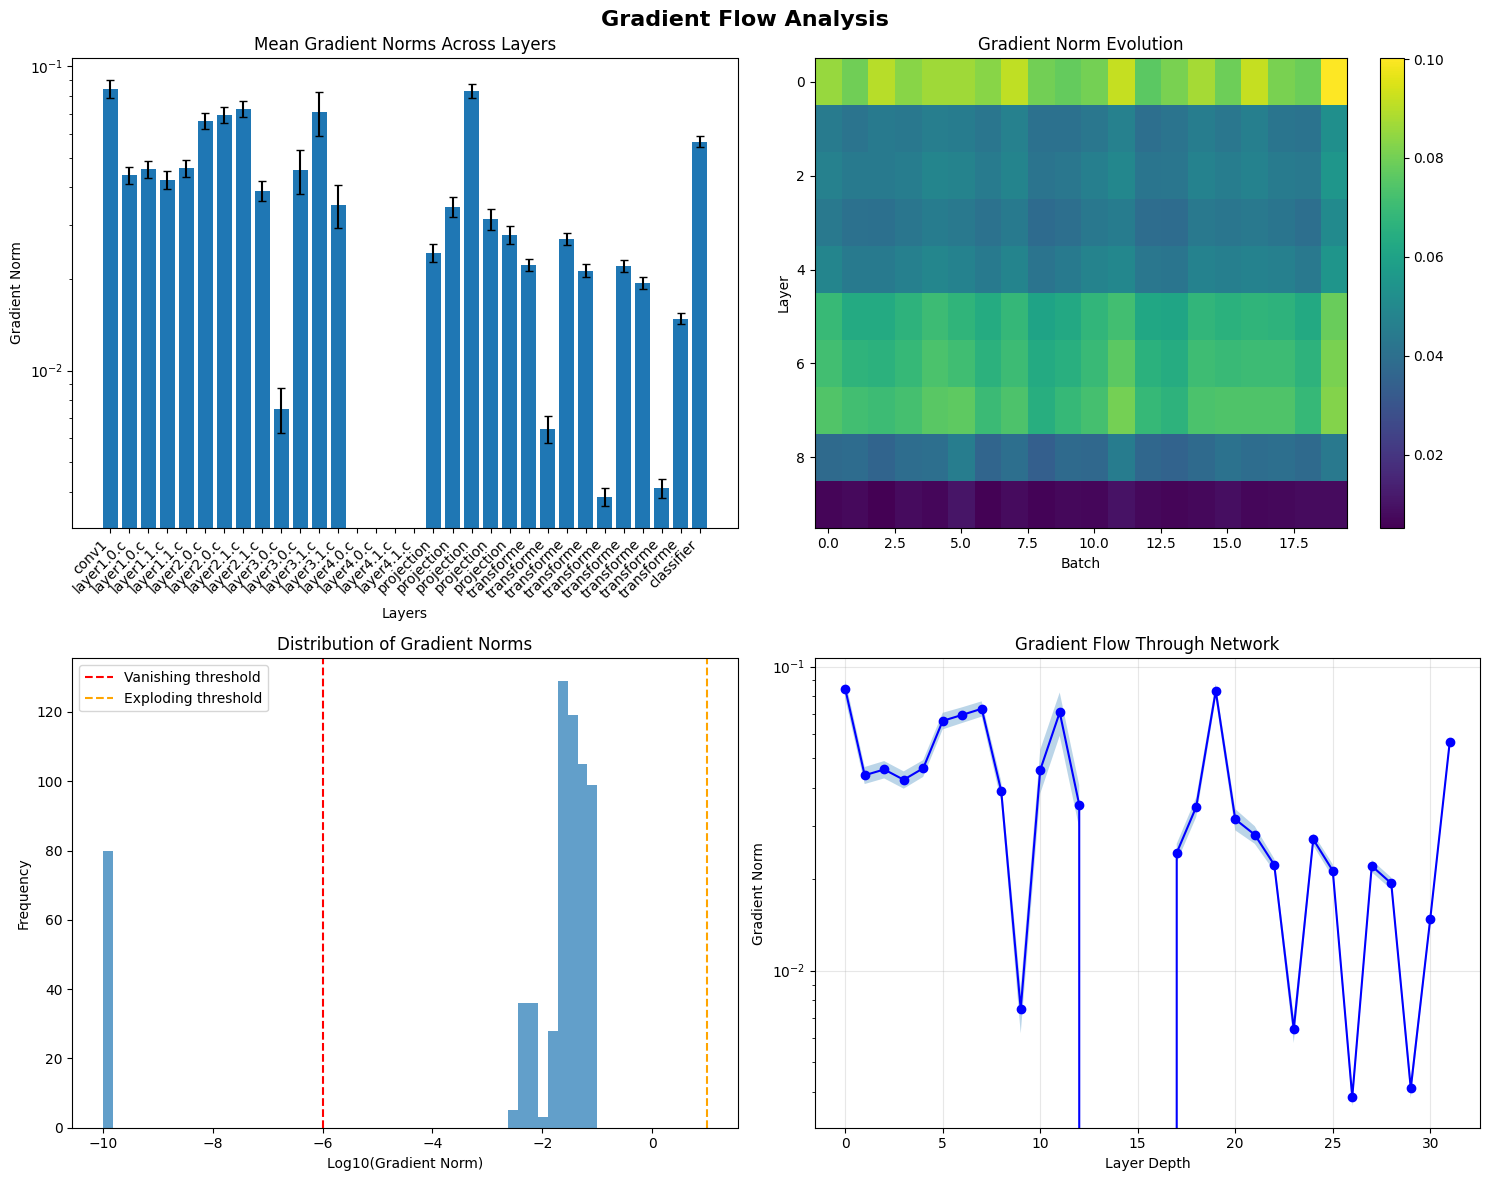

Gradient flow analyzer hooks cleaned up.

Total Training Time: 1h 18m 54s

--- Top-K Accuracy Results ---
Top-1 Accuracy: 69.88%
Top-3 Accuracy: 93.92%
Top-5 Accuracy: 98.64%

--- Additional Performance Metrics ---
Macro Average Precision: 0.6318
Macro Average Recall: 0.6125
Macro Average F1-Score: 0.6175
Weighted Average Precision: 0.6959
Weighted Average Recall: 0.6988
Weighted Average F1-Score: 0.6945

--- Model Confidence & Calibration Metrics ---
Average Prediction Confidence: 0.7381
Confidence Standard Deviation: 0.2084
Average Prediction Entropy: 0.7242
Expected Calibration Error: 0.0393

Final Test Loss: 0.8346

--- Model Parameters ---
  Total: 12.85M (12,850,760)
  Trainable: 12.85M (12,850,760)
  Non-trainable: 0 (0)
  Memory (float32): ~49.0 MB

--- Gradient Flow Analysis Report ---
Overall Gradient Health Score: 80.00%
⚠️  Good gradient flow - some layers may need attention
🔍 VANISHING GRADIENTS DETECTED (4 layers):
  - layer4.0.conv1_Conv2d_13: 0.00e+00 [HIGH]
  - layer4.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import os
import time
import requests
import zipfile
import shutil
from tqdm import tqdm
import time
import sys
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import torch.nn.functional as F
import medmnist
from medmnist import INFO

# --- Configuration Parameters ---
CONFIG = {
    "batch_size": 128,
    "num_epochs": 100,
    "learning_rate": 0.001,
    "weight_decay": 1e-4,
    "split_seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_path": "./best_model.pth",
}

# --- Transformer Configuration ---
TRANSFORMER_CONFIG = {
    "embedding_dim": 256,       # Dimension of the tokens fed to the transformer
    "nhead": 8,                 # Number of attention heads
    "num_encoder_layers": 3,    # Number of transformer encoder layers
    "dim_feedforward": 512,     # Hidden dimension in the feed-forward network
    "dropout": 0.1,
}

# ==========================================
# Callback Classes
# ==========================================

class Callback:
    """Base callback class"""
    def on_epoch_end(self, epoch, logs=None):
        pass

    def on_training_end(self):
        pass

class ReduceLROnPlateau(Callback):
    """Reduce learning rate when a metric has stopped improving"""
    def __init__(self, optimizer, monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-7, verbose=1):
        self.optimizer = optimizer
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.mode = 'min' if 'loss' in monitor else 'max'

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return

        current = logs.get(self.monitor)
        if current is None:
            return

        if self.best is None:
            self.best = current
            return

        if self.mode == 'min':
            improved = current < self.best
        else:
            improved = current > self.best

        if improved:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = self.optimizer.param_groups[0]['lr']
                new_lr = max(old_lr * self.factor, self.min_lr)
                if new_lr != old_lr:
                    self.optimizer.param_groups[0]['lr'] = new_lr
                    if self.verbose:
                        print(f"\nReducing learning rate from {old_lr:.2e} to {new_lr:.2e}")
                    self.wait = 0

class EarlyStopping(Callback):
    """Stop training when a monitored metric has stopped improving"""
    def __init__(self, monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1):
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.best_weights = None
        self.mode = 'min' if 'loss' in monitor else 'max'
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None, model=None):
        if logs is None:
            return False

        current = logs.get(self.monitor)
        if current is None:
            return False

        if self.best is None:
            self.best = current
            if model is not None and self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
            return False

        if self.mode == 'min':
            improved = current < self.best
        else:
            improved = current > self.best

        if improved:
            self.best = current
            self.wait = 0
            if model is not None and self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if self.verbose:
                    print(f"\nEarly stopping at epoch {epoch + 1}")
                return True
        return False

    def on_training_end(self, model=None):
        if self.stopped_epoch > 0 and self.verbose:
            print(f"Restored model weights from the end of the best epoch: {self.stopped_epoch + 1 - self.patience}")
        if model is not None and self.restore_best_weights and self.best_weights is not None:
            model.load_state_dict(self.best_weights)

class ModelCheckpoint(Callback):
    """Save the model after every epoch"""
    def __init__(self, filepath, save_best_only=True, monitor='val_accuracy', verbose=1):
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.monitor = monitor
        self.verbose = verbose
        self.best = None
        self.mode = 'min' if 'loss' in monitor else 'max'

    def on_epoch_end(self, epoch, logs=None, model=None):
        if logs is None or model is None:
            return

        current = logs.get(self.monitor)
        if current is None:
            return

        if not self.save_best_only:
            filepath = self.filepath.replace('.pth', f'_epoch_{epoch + 1}.pth')
            torch.save(model.state_dict(), filepath)
            if self.verbose:
                print(f"\nModel saved to {filepath}")
            return

        if self.best is None:
            self.best = current
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(f"\nModel saved to {self.filepath}")
            return

        if self.mode == 'min':
            improved = current < self.best
        else:
            improved = current > self.best

        if improved:
            self.best = current
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(f"\nModel saved to {self.filepath}")

# ==========================================
# Data Preprocessing
# ==========================================

def get_dataloaders(config):
    """Downloads, prepares MedMNIST data with augmentation, returning DataLoaders."""

    # MedMNIST dataset configuration
    dataset_name = "tissuemnist"  # Options: pathmnist, chestmnist, dermamnist, octmnist, pneumoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist

    # Get dataset info
    info = INFO[dataset_name]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    print(f"Dataset: {dataset_name}")
    print(f"Task: {task}")
    print(f"Number of channels: {n_channels}")
    print(f"Number of classes: {n_classes}")

    # Update config with dataset info
    config["num_classes"] = n_classes

    # Get the dataset class
    DataClass = getattr(medmnist, info['python_class'])

    # Define transforms
    # Training transforms (with augmentation)
    train_transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize to match original Tiny ImageNet size
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        # Convert grayscale to RGB if needed
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation/Test transforms (no augmentation)
    val_test_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    print(f"Loading {dataset_name} dataset...")

    # Load datasets - MedMNIST provides predefined train/val/test splits
    train_dataset = DataClass(
        split='train',
        transform=train_transform,
        download=True,  # Will download if not present
        as_rgb=False    # We handle RGB conversion in transforms
    )

    val_dataset = DataClass(
        split='val',
        transform=val_test_transform,
        download=True,
        as_rgb=False
    )

    test_dataset = DataClass(
        split='test',
        transform=val_test_transform,
        download=True,
        as_rgb=False
    )

    print(f"Dataset splits - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Handle different task types
    if task == 'multi-label, binary-class':
        def collate_fn(batch):
            images = torch.stack([item[0] for item in batch])
            # Fix: Convert to numpy array first, then to tensor
            labels_np = np.array([item[1] for item in batch])
            labels = torch.tensor(labels_np, dtype=torch.float32).squeeze()
            return images, labels
    else:
        def collate_fn(batch):
            images = torch.stack([item[0] for item in batch])
            # Fix: Convert to numpy array first, then to tensor
            labels_np = np.array([item[1] for item in batch])
            labels = torch.tensor(labels_np, dtype=torch.long).squeeze()
            return images, labels

    # Set worker init function for reproducible DataLoader behavior
    def worker_init_fn(worker_id):
        np.random.seed(config["split_seed"] + worker_id)

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config["batch_size"],
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        collate_fn=collate_fn,
        generator=torch.Generator().manual_seed(config["split_seed"])
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        collate_fn=collate_fn
    )

    return train_loader, val_loader, test_loader

# ==========================================
# Model Architecture and Training
# ==========================================

class NonResidualBlock(nn.Module):
    """A standard convolutional block WITHOUT the residual connection."""
    def __init__(self, in_channels, out_channels, stride=1):
        super(NonResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

class ResNetTransformer(nn.Module):
    """
    A hybrid architecture combining a non-residual CNN backbone with a Transformer encoder,
    including positional embeddings.
    """
    def __init__(self, block, layers, num_classes, t_config):
        super(ResNetTransformer, self).__init__()
        self.in_channels = 64
        self.embedding_dim = t_config["embedding_dim"]
        self.num_tokens = len(layers) + 1  # 4 layers + 1 initial capture

        # 1. CNN Backbone (Feature Extractor)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # 2. Projection heads to create tokens from feature maps
        self.projections = nn.ModuleList([
            self._create_projection(64, self.embedding_dim),
            self._create_projection(64, self.embedding_dim),
            self._create_projection(128, self.embedding_dim),
            self._create_projection(256, self.embedding_dim),
            self._create_projection(512, self.embedding_dim)
        ])

        # 3. Learnable Positional Embedding
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_tokens, self.embedding_dim))

        # 4. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embedding_dim,
            nhead=t_config["nhead"],
            dim_feedforward=t_config["dim_feedforward"],
            dropout=t_config["dropout"],
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=t_config["num_encoder_layers"]
        )

        # 5. Final Classifier
        self.classifier = nn.Linear(self.embedding_dim, num_classes)

    def _create_projection(self, in_features, out_features):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features, out_features)
        )

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        current_in_channels = self.in_channels
        for s in strides:
            layers.append(block(current_in_channels, out_channels, s))
            current_in_channels = out_channels
        self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # 1. Pass through CNN backbone and capture features
        features = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        features.append(x)  # Capture 1: After initial maxpool

        x = self.layer1(x); features.append(x)  # Capture 2: After layer1
        x = self.layer2(x); features.append(x)  # Capture 3: After layer2
        x = self.layer3(x); features.append(x)  # Capture 4: After layer3
        x = self.layer4(x); features.append(x)  # Capture 5: After layer4

        # 2. Project features to tokens
        tokens = [self.projections[i](feature_map) for i, feature_map in enumerate(features)]

        # 3. Stack tokens into a sequence
        token_sequence = torch.stack(tokens, dim=1)

        # 4. Add positional embedding
        token_sequence += self.positional_embedding

        # 5. Pass through Transformer
        transformer_out = self.transformer_encoder(token_sequence)

        # 6. Aggregate and classify
        aggregated_vector = transformer_out.mean(dim=1)
        logits = self.classifier(aggregated_vector)

        return logits

def evaluate_model(model, data_loader, criterion, device):
    """Evaluates the model on a given dataset."""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_and_validate(model, train_loader, val_loader, config):
    """Main training loop with callbacks."""
    device = config["device"]
    model.to(device)

    # Set seeds for reproducible training
    torch.manual_seed(config["split_seed"])
    np.random.seed(config["split_seed"])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(config["split_seed"])
        torch.cuda.manual_seed_all(config["split_seed"])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    # Initialize callbacks
    callbacks = [
        ReduceLROnPlateau(
            optimizer=optimizer,
            monitor='val_accuracy',
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=config["checkpoint_path"],
            save_best_only=True,
            monitor='val_accuracy',
            verbose=1
        )
    ]

    print("\n--- Starting Training ---")
    early_stop = False

    for epoch in range(config["num_epochs"]):
        if early_stop:
            break

        model.train()
        start_time = time.time()
        running_loss, train_correct, train_total = 0.0, 0, 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Train]", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / train_total
        train_acc = 100 * train_correct / train_total
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{config['num_epochs']} | Time: {time.time() - start_time:.2f}s | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Prepare logs for callbacks
        logs = {
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
        }

        # Execute callbacks
        for callback in callbacks:
            if isinstance(callback, EarlyStopping):
                if callback.on_epoch_end(epoch, logs, model):
                    early_stop = True
                    break
            elif isinstance(callback, ModelCheckpoint):
                callback.on_epoch_end(epoch, logs, model)
            else:
                callback.on_epoch_end(epoch, logs)

    # Execute callback cleanup
    for callback in callbacks:
        if isinstance(callback, EarlyStopping):
            callback.on_training_end(model)
        else:
            callback.on_training_end()

    print("--- Training Finished ---\n")
    return model

# ==========================================
# Evaluation
# ==========================================

def calculate_top_k_accuracy(outputs, labels, k_values=[1, 3, 5]):
    """Calculate top-k accuracy for given k values."""
    batch_size = labels.size(0)
    _, pred = outputs.topk(max(k_values), 1, True, True)
    pred = pred.t()
    correct = pred.eq(labels.view(1, -1).expand_as(pred))

    top_k_accuracies = {}
    for k in k_values:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        top_k_accuracies[k] = correct_k.item() / batch_size

    return top_k_accuracies

def calculate_entropy(probs):
    """Calculate entropy of probability distributions."""
    # Add small epsilon to avoid log(0)
    epsilon = 1e-8
    probs = probs + epsilon
    entropy = -torch.sum(probs * torch.log(probs), dim=1)
    return entropy

def calculate_ece(confidences, accuracies, n_bins=10):
    """Calculate Expected Calibration Error."""
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower.item()) & (confidences <= bin_upper.item())
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece.item()

def comprehensive_evaluation(model, test_loader, criterion, device):
    """Comprehensive evaluation with all requested metrics."""
    model.eval()

    all_predictions = []
    all_labels = []
    all_confidences = []
    all_entropies = []
    all_top_k_results = {1: [], 3: [], 5: []}
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Convert outputs to probabilities
            probs = torch.softmax(outputs, dim=1)

            # Get predictions and confidences
            confidences, predictions = torch.max(probs, dim=1)

            # Calculate entropy
            entropies = calculate_entropy(probs)

            # Calculate top-k accuracies
            top_k_accs = calculate_top_k_accuracy(outputs, labels, [1, 3, 5])

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
            all_entropies.extend(entropies.cpu().numpy())

            for k in [1, 3, 5]:
                all_top_k_results[k].extend([top_k_accs[k]] * labels.size(0))

            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_confidences = np.array(all_confidences)
    all_entropies = np.array(all_entropies)

    # Calculate basic metrics
    avg_loss = total_loss / total_samples

    # Calculate top-k accuracies
    top1 = np.mean([pred == label for pred, label in zip(all_predictions, all_labels)])
    top3 = np.mean(all_top_k_results[3])
    top5 = np.mean(all_top_k_results[5])

    # Calculate precision, recall, f1-score
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='macro', zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted', zero_division=0
    )

    # Calculate confidence and calibration metrics
    avg_confidence = np.mean(all_confidences)
    std_confidence = np.std(all_confidences)
    avg_entropy = np.mean(all_entropies)

    # Calculate ECE
    accuracies = (all_predictions == all_labels).astype(float)
    ece = calculate_ece(torch.tensor(all_confidences), torch.tensor(accuracies))

    return {
        'test_loss': avg_loss,
        'top1': top1,
        'top3': top3,
        'top5': top5,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'avg_confidence': avg_confidence,
        'std_confidence': std_confidence,
        'avg_entropy': avg_entropy,
        'ece': ece
    }

def analyze_gradient_flow(model, data_loader, device, num_batches=10, plot=True, save_plot_path=None):
    """
    Convenience function to perform complete gradient flow analysis.

    Args:
        model: PyTorch model to analyze
        data_loader: DataLoader for the dataset
        device: Device to run analysis on
        num_batches: Number of batches to analyze
        plot: Whether to generate plots
        save_plot_path: Path to save plots (optional)

    Returns:
        dict: Analysis results
        str: Text report
    """
    analyzer = GradientFlowAnalyzer(model, device)

    try:
        # Perform analysis
        results = analyzer.analyze_batch_gradients(data_loader, num_batches)

        # Generate report
        report = analyzer.generate_report()

        # Create plots if requested
        if plot:
            analyzer.plot_gradient_flow(save_plot_path)

        return results, report

    finally:
        # Always cleanup hooks
        analyzer.cleanup()

def print_model_parameters(model):
    """Print model parameter counts in a simple format."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable = total - trainable

    def format_num(num):
        if num >= 1e6:
            return f"{num/1e6:.2f}M"
        elif num >= 1e3:
            return f"{num/1e3:.2f}K"
        else:
            return str(num)

    print("\n--- Model Parameters ---")
    print(f"  Total: {format_num(total)} ({total:,})")
    print(f"  Trainable: {format_num(trainable)} ({trainable:,})")
    print(f"  Non-trainable: {format_num(non_trainable)} ({non_trainable:,})")
    print(f"  Memory (float32): ~{total * 4 / 1024**2:.1f} MB")

def print_training_time(start_time, end_time):
    """Print formatted training time."""
    def format_time(seconds):
        """Format seconds into human-readable time."""
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        seconds = int(seconds % 60)

        if hours > 0:
            return f"{hours}h {minutes}m {seconds}s"
        elif minutes > 0:
            return f"{minutes}m {seconds}s"
        else:
            return f"{seconds}s"

    total_time = end_time - start_time
    print(f"\nTotal Training Time: {format_time(total_time)}")

# ==========================================
# Main Execution
# ==========================================

if __name__ == '__main__':
    # Set global seeds for full reproducibility
    torch.manual_seed(CONFIG["split_seed"])
    np.random.seed(CONFIG["split_seed"])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(CONFIG["split_seed"])
        torch.cuda.manual_seed_all(CONFIG["split_seed"])
        # Ensure deterministic behavior on CUDA
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    print(f"Using device: {CONFIG['device']}")
    print(f"Reproducibility seed: {CONFIG['split_seed']}")

    # Get data loaders
    dataloaders = get_dataloaders(CONFIG)
    if dataloaders is None:
        print("Could not prepare data. Halting execution.", file=sys.stderr)
        sys.exit(1)  # Exit if data preparation failed

    train_loader, val_loader, test_loader = dataloaders

    # Initialize and train model
    model = ResNetTransformer(
        block=NonResidualBlock,
        layers=[2, 2, 2, 2],
        num_classes=CONFIG["num_classes"],
        t_config=TRANSFORMER_CONFIG
    )
    training_start_time = time.time()
    trained_model = train_and_validate(model, train_loader, val_loader, CONFIG)
    training_end_time = time.time()

    # Comprehensive evaluation on the test set
    print("--- Starting Comprehensive Evaluation on Test Set ---")
    results = comprehensive_evaluation(trained_model, test_loader, nn.CrossEntropyLoss(), CONFIG["device"])

    # Perform gradient flow analysis
    print("\n--- Starting Gradient Flow Analysis ---")
    gradient_results, gradient_report = analyze_gradient_flow(
        model=model,
        data_loader=test_loader,
        device=CONFIG["device"],
        num_batches=20,  # Analyze 20 batches for comprehensive results
        plot=True,
        save_plot_path="gradient_flow_analysis.png"
    )

    # Print all requested metrics
    print_training_time(training_start_time, training_end_time)

    print("\n--- Top-K Accuracy Results ---")
    print(f"Top-1 Accuracy: {results['top1'] * 100:.2f}%")
    print(f"Top-3 Accuracy: {results['top3'] * 100:.2f}%")
    print(f"Top-5 Accuracy: {results['top5'] * 100:.2f}%")

    print("\n--- Additional Performance Metrics ---")
    print(f"Macro Average Precision: {results['precision_macro']:.4f}")
    print(f"Macro Average Recall: {results['recall_macro']:.4f}")
    print(f"Macro Average F1-Score: {results['f1_macro']:.4f}")
    print(f"Weighted Average Precision: {results['precision_weighted']:.4f}")
    print(f"Weighted Average Recall: {results['recall_weighted']:.4f}")
    print(f"Weighted Average F1-Score: {results['f1_weighted']:.4f}")

    print("\n--- Model Confidence & Calibration Metrics ---")
    print(f"Average Prediction Confidence: {results['avg_confidence']:.4f}")
    print(f"Confidence Standard Deviation: {results['std_confidence']:.4f}")
    print(f"Average Prediction Entropy: {results['avg_entropy']:.4f}")
    print(f"Expected Calibration Error: {results['ece']:.4f}")

    print(f"\nFinal Test Loss: {results['test_loss']:.4f}")

    print_model_parameters(model)

    print(gradient_report)
    print("=" * 60)

## Hybrid Transformer on ResNet-18 (RoPE)

Using device: cuda
Reproducibility seed: 42
Dataset: tissuemnist
Task: multi-class
Number of channels: 1
Number of classes: 8
Loading tissuemnist dataset...
Dataset splits - Train: 165466, Val: 23640, Test: 47280

--- Starting Training ---


Epoch 1/100 | Time: 156.35s | Train Loss: 1.2416, Train Acc: 52.98% | Val Loss: 1.1574, Val Acc: 55.54%

Model saved to ./best_model.pth


Epoch 2/100 | Time: 156.72s | Train Loss: 1.0925, Train Acc: 59.43% | Val Loss: 1.3759, Val Acc: 52.12%


Epoch 3/100 | Time: 157.02s | Train Loss: 1.0295, Train Acc: 61.90% | Val Loss: 1.0860, Val Acc: 60.44%

Model saved to ./best_model.pth


Epoch 4/100 | Time: 158.81s | Train Loss: 0.9991, Train Acc: 63.14% | Val Loss: 0.9812, Val Acc: 64.41%

Model saved to ./best_model.pth


Epoch 5/100 | Time: 161.84s | Train Loss: 0.9770, Train Acc: 64.00% | Val Loss: 1.0835, Val Acc: 59.98%


Epoch 6/100 | Time: 157.32s | Train Loss: 0.9592, Train Acc: 64.78% | Val Loss: 1.0048, Val Acc: 63.79%


Epoch 7/100 | Time: 161.69s | Train Loss: 0.9482, Train Acc: 65.24% | Val Loss: 1.0917, Val Acc: 58.94%

Reducing learning rate from 1.00e-03 to 2.00e-04


Epoch 8/100 | Time: 156.60s | Train Loss: 0.8822, Train Acc: 67.69% | Val Loss: 0.9096, Val Acc: 66.54%

Model saved to ./best_model.pth


Epoch 9/100 | Time: 156.62s | Train Loss: 0.8657, Train Acc: 68.46% | Val Loss: 0.8764, Val Acc: 67.80%

Model saved to ./best_model.pth


Epoch 10/100 | Time: 156.37s | Train Loss: 0.8555, Train Acc: 68.77% | Val Loss: 0.8548, Val Acc: 69.15%

Model saved to ./best_model.pth


Epoch 11/100 | Time: 155.37s | Train Loss: 0.8473, Train Acc: 69.04% | Val Loss: 0.8659, Val Acc: 68.43%


Epoch 12/100 | Time: 155.79s | Train Loss: 0.8426, Train Acc: 69.30% | Val Loss: 0.8672, Val Acc: 68.36%


Epoch 13/100 | Time: 157.44s | Train Loss: 0.8361, Train Acc: 69.51% | Val Loss: 0.8690, Val Acc: 68.22%

Reducing learning rate from 2.00e-04 to 4.00e-05


Epoch 14/100 | Time: 155.72s | Train Loss: 0.8116, Train Acc: 70.60% | Val Loss: 0.8444, Val Acc: 69.24%

Model saved to ./best_model.pth


Epoch 15/100 | Time: 158.70s | Train Loss: 0.8073, Train Acc: 70.71% | Val Loss: 0.8392, Val Acc: 69.42%

Model saved to ./best_model.pth


Epoch 16/100 | Time: 161.18s | Train Loss: 0.8019, Train Acc: 70.95% | Val Loss: 0.8319, Val Acc: 69.89%

Model saved to ./best_model.pth


Epoch 17/100 | Time: 157.84s | Train Loss: 0.7987, Train Acc: 71.01% | Val Loss: 0.8382, Val Acc: 69.60%


Epoch 18/100 | Time: 157.50s | Train Loss: 0.7973, Train Acc: 70.96% | Val Loss: 0.8326, Val Acc: 69.70%


Epoch 19/100 | Time: 157.13s | Train Loss: 0.7958, Train Acc: 71.11% | Val Loss: 0.8337, Val Acc: 69.78%

Reducing learning rate from 4.00e-05 to 8.00e-06


Epoch 20/100 | Time: 156.77s | Train Loss: 0.7870, Train Acc: 71.56% | Val Loss: 0.8329, Val Acc: 69.79%


Epoch 21/100 | Time: 155.68s | Train Loss: 0.7870, Train Acc: 71.46% | Val Loss: 0.8302, Val Acc: 69.90%

Model saved to ./best_model.pth


Epoch 22/100 | Time: 161.28s | Train Loss: 0.7848, Train Acc: 71.59% | Val Loss: 0.8278, Val Acc: 69.99%

Model saved to ./best_model.pth


Epoch 23/100 | Time: 157.89s | Train Loss: 0.7855, Train Acc: 71.45% | Val Loss: 0.8282, Val Acc: 69.95%


Epoch 24/100 | Time: 165.31s | Train Loss: 0.7841, Train Acc: 71.60% | Val Loss: 0.8291, Val Acc: 70.02%

Model saved to ./best_model.pth


Epoch 25/100 | Time: 160.17s | Train Loss: 0.7835, Train Acc: 71.65% | Val Loss: 0.8290, Val Acc: 69.92%


Epoch 26/100 | Time: 159.91s | Train Loss: 0.7823, Train Acc: 71.61% | Val Loss: 0.8301, Val Acc: 69.97%


Epoch 27/100 | Time: 163.16s | Train Loss: 0.7812, Train Acc: 71.68% | Val Loss: 0.8283, Val Acc: 69.99%

Reducing learning rate from 8.00e-06 to 1.60e-06


Epoch 28/100 | Time: 161.84s | Train Loss: 0.7798, Train Acc: 71.68% | Val Loss: 0.8305, Val Acc: 69.95%


Epoch 29/100 | Time: 161.04s | Train Loss: 0.7821, Train Acc: 71.56% | Val Loss: 0.8279, Val Acc: 69.99%


Epoch 30/100 | Time: 161.67s | Train Loss: 0.7807, Train Acc: 71.62% | Val Loss: 0.8302, Val Acc: 69.86%

Reducing learning rate from 1.60e-06 to 3.20e-07


Epoch 31/100 | Time: 164.64s | Train Loss: 0.7804, Train Acc: 71.71% | Val Loss: 0.8336, Val Acc: 69.76%

Early stopping at epoch 31
Restored model weights from the end of the best epoch: 24
--- Training Finished ---

--- Starting Comprehensive Evaluation on Test Set ---


Evaluating: 100%|██████████| 370/370 [00:19<00:00, 18.63it/s]



--- Starting Gradient Flow Analysis ---
Analyzing gradient flow over 20 batches...


Gradient Flow Analysis:   0%|          | 0/370 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Gradient Flow Analysis:   5%|▌         | 20/370 [00:02<00:38,  9.01it/s]


Gradient flow plots saved to gradient_flow_analysis.png


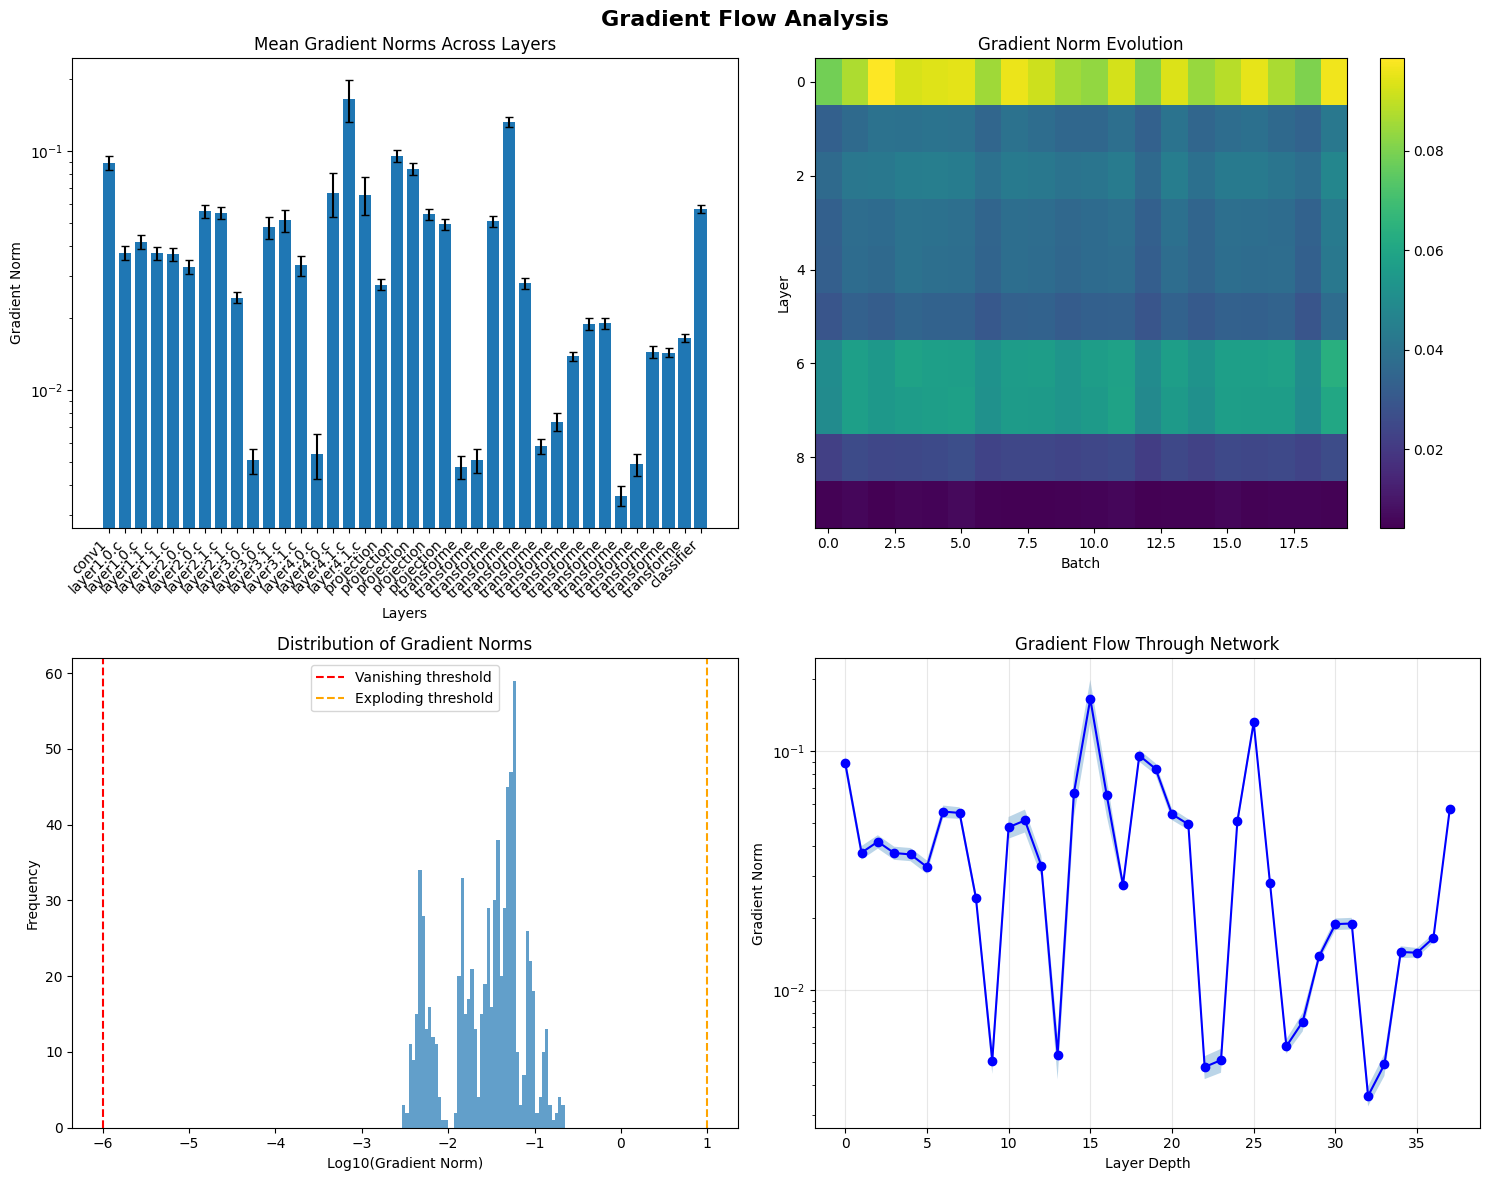

Gradient flow analyzer hooks cleaned up.

Total Training Time: 1h 22m 6s

--- Top-K Accuracy Results ---
Top-1 Accuracy: 69.72%
Top-3 Accuracy: 93.98%
Top-5 Accuracy: 98.63%

--- Additional Performance Metrics ---
Macro Average Precision: 0.6324
Macro Average Recall: 0.6095
Macro Average F1-Score: 0.6157
Weighted Average Precision: 0.6945
Weighted Average Recall: 0.6972
Weighted Average F1-Score: 0.6924

--- Model Confidence & Calibration Metrics ---
Average Prediction Confidence: 0.7298
Confidence Standard Deviation: 0.2087
Average Prediction Entropy: 0.7488
Expected Calibration Error: 0.0326

Final Test Loss: 0.8342

--- Model Parameters ---
  Total: 12.85M (12,847,176)
  Trainable: 12.85M (12,847,176)
  Non-trainable: 0 (0)
  Memory (float32): ~49.0 MB

--- Gradient Flow Analysis Report ---
Overall Gradient Health Score: 92.68%
✅ Excellent gradient flow - most layers have healthy gradients
✅ No vanishing gradient issues detected
✅ No exploding gradient issues detected
📉 Average grad

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import os
import time
import requests
import zipfile
import shutil
from tqdm import tqdm
import time
import sys
import math
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import medmnist
from medmnist import INFO

# --- Configuration Parameters ---
CONFIG = {
    "batch_size": 128,
    "num_epochs": 100,
    "learning_rate": 0.001,
    "weight_decay": 1e-4,
    "split_seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_path": "./best_model.pth",
}

# --- Transformer Configuration ---
TRANSFORMER_CONFIG = {
    "embedding_dim": 256,
    "nhead": 8,
    "num_encoder_layers": 3,
    "dim_feedforward": 512,
    "dropout": 0.1,
}

# ==========================================
# Callback Classes
# ==========================================

class Callback:
    """Base callback class"""
    def on_epoch_end(self, epoch, logs=None):
        pass

    def on_training_end(self):
        pass

class ReduceLROnPlateau(Callback):
    """Reduce learning rate when a metric has stopped improving"""
    def __init__(self, optimizer, monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-7, verbose=1):
        self.optimizer = optimizer
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.mode = 'min' if 'loss' in monitor else 'max'

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return

        current = logs.get(self.monitor)
        if current is None:
            return

        if self.best is None:
            self.best = current
            return

        if self.mode == 'min':
            improved = current < self.best
        else:
            improved = current > self.best

        if improved:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = self.optimizer.param_groups[0]['lr']
                new_lr = max(old_lr * self.factor, self.min_lr)
                if new_lr != old_lr:
                    self.optimizer.param_groups[0]['lr'] = new_lr
                    if self.verbose:
                        print(f"\nReducing learning rate from {old_lr:.2e} to {new_lr:.2e}")
                    self.wait = 0

class EarlyStopping(Callback):
    """Stop training when a monitored metric has stopped improving"""
    def __init__(self, monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1):
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.best_weights = None
        self.mode = 'min' if 'loss' in monitor else 'max'
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None, model=None):
        if logs is None:
            return False

        current = logs.get(self.monitor)
        if current is None:
            return False

        if self.best is None:
            self.best = current
            if model is not None and self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
            return False

        if self.mode == 'min':
            improved = current < self.best
        else:
            improved = current > self.best

        if improved:
            self.best = current
            self.wait = 0
            if model is not None and self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if self.verbose:
                    print(f"\nEarly stopping at epoch {epoch + 1}")
                return True
        return False

    def on_training_end(self, model=None):
        if self.stopped_epoch > 0 and self.verbose:
            print(f"Restored model weights from the end of the best epoch: {self.stopped_epoch + 1 - self.patience}")
        if model is not None and self.restore_best_weights and self.best_weights is not None:
            model.load_state_dict(self.best_weights)

class ModelCheckpoint(Callback):
    """Save the model after every epoch"""
    def __init__(self, filepath, save_best_only=True, monitor='val_accuracy', verbose=1):
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.monitor = monitor
        self.verbose = verbose
        self.best = None
        self.mode = 'min' if 'loss' in monitor else 'max'

    def on_epoch_end(self, epoch, logs=None, model=None):
        if logs is None or model is None:
            return

        current = logs.get(self.monitor)
        if current is None:
            return

        if not self.save_best_only:
            filepath = self.filepath.replace('.pth', f'_epoch_{epoch + 1}.pth')
            torch.save(model.state_dict(), filepath)
            if self.verbose:
                print(f"\nModel saved to {filepath}")
            return

        if self.best is None:
            self.best = current
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(f"\nModel saved to {self.filepath}")
            return

        if self.mode == 'min':
            improved = current < self.best
        else:
            improved = current > self.best

        if improved:
            self.best = current
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(f"\nModel saved to {self.filepath}")

# ==========================================
# Data Preprocessing
# ==========================================

def get_dataloaders(config):
    """Downloads, prepares MedMNIST data with augmentation, returning DataLoaders."""

    # MedMNIST dataset configuration
    dataset_name = "tissuemnist"  # Options: pathmnist, chestmnist, dermamnist, octmnist, pneumoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist

    # Get dataset info
    info = INFO[dataset_name]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    print(f"Dataset: {dataset_name}")
    print(f"Task: {task}")
    print(f"Number of channels: {n_channels}")
    print(f"Number of classes: {n_classes}")

    # Update config with dataset info
    config["num_classes"] = n_classes

    # Get the dataset class
    DataClass = getattr(medmnist, info['python_class'])

    # Define transforms
    # Training transforms (with augmentation)
    train_transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize to match original Tiny ImageNet size
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        # Convert grayscale to RGB if needed
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation/Test transforms (no augmentation)
    val_test_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    print(f"Loading {dataset_name} dataset...")

    # Load datasets - MedMNIST provides predefined train/val/test splits
    train_dataset = DataClass(
        split='train',
        transform=train_transform,
        download=True,  # Will download if not present
        as_rgb=False    # We handle RGB conversion in transforms
    )

    val_dataset = DataClass(
        split='val',
        transform=val_test_transform,
        download=True,
        as_rgb=False
    )

    test_dataset = DataClass(
        split='test',
        transform=val_test_transform,
        download=True,
        as_rgb=False
    )

    print(f"Dataset splits - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Handle different task types
    if task == 'multi-label, binary-class':
        def collate_fn(batch):
            images = torch.stack([item[0] for item in batch])
            # Fix: Convert to numpy array first, then to tensor
            labels_np = np.array([item[1] for item in batch])
            labels = torch.tensor(labels_np, dtype=torch.float32).squeeze()
            return images, labels
    else:
        def collate_fn(batch):
            images = torch.stack([item[0] for item in batch])
            # Fix: Convert to numpy array first, then to tensor
            labels_np = np.array([item[1] for item in batch])
            labels = torch.tensor(labels_np, dtype=torch.long).squeeze()
            return images, labels

    # Set worker init function for reproducible DataLoader behavior
    def worker_init_fn(worker_id):
        np.random.seed(config["split_seed"] + worker_id)

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config["batch_size"],
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        collate_fn=collate_fn,
        generator=torch.Generator().manual_seed(config["split_seed"])
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        collate_fn=collate_fn
    )

    return train_loader, val_loader, test_loader

# ==========================================
# Model Architecture and Training
# ==========================================

class RotaryEmbedding(nn.Module):
    """
    The Rotary Positional Embedding (RoPE) module.
    This implementation is based on the paper "RoFormer: Enhanced Transformer with Rotary Position Embedding".
    """
    def __init__(self, dim, base=10000):
        super().__init__()
        self.dim = dim
        self.base = base
        # Create inverse frequencies and register as a buffer
        inv_freq = 1.0 / (self.base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.seq_len_cached = None
        self.cos_cached = None
        self.sin_cached = None

    def forward(self, x):
        seq_len = x.shape[1]
        # Check if we need to recompute the cache
        if seq_len != self.seq_len_cached:
            self.seq_len_cached = seq_len
            t = torch.arange(seq_len, device=x.device).type_as(self.inv_freq)
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)
            self.cos_cached = emb.cos()[:, None, :]
            self.sin_cached = emb.sin()[:, None, :]

        # Apply the rotation
        return self.cos_cached, self.sin_cached

def rotate_half(x):
    x1, x2 = x[..., : x.shape[-1] // 2], x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=x1.ndim - 1)

def apply_rotary_pos_emb(q, k, cos, sin):
    return (q * cos) + (rotate_half(q) * sin), (k * cos) + (rotate_half(k) * sin)

class MultiHeadAttentionWithRoPE(nn.Module):
    """Custom Multi-Head Attention with RoPE support"""
    def __init__(self, d_model, nhead, dropout=0.1, batch_first=True):
        super().__init__()
        assert d_model % nhead == 0

        self.d_model = d_model
        self.nhead = nhead
        self.d_k = d_model // nhead
        self.batch_first = batch_first  # Add this attribute

        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.rotary_emb = RotaryEmbedding(self.d_k)

    def forward(self, query, key, value, key_padding_mask=None, attn_mask=None, need_weights=False, is_causal=False):
        batch_size, seq_len, _ = query.size()

        # Linear transformations
        Q = self.w_q(query)  # [batch_size, seq_len, d_model]
        K = self.w_k(key)    # [batch_size, seq_len, d_model]
        V = self.w_v(value)  # [batch_size, seq_len, d_model]

        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.nhead, self.d_k)  # [batch, seq, heads, d_k]
        K = K.view(batch_size, seq_len, self.nhead, self.d_k)
        V = V.view(batch_size, seq_len, self.nhead, self.d_k)

        # Apply RoPE to Q and K
        cos, sin = self.rotary_emb(query)
        Q, K = apply_rotary_pos_emb(Q, K, cos, sin)

        # Transpose for attention computation: [batch, heads, seq, d_k]
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply masks if provided
        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask == 0, -1e9)

        if key_padding_mask is not None:
            # key_padding_mask: [batch_size, seq_len], True for padding positions
            key_padding_mask = key_padding_mask.unsqueeze(1).unsqueeze(2)  # [batch, 1, 1, seq]
            scores = scores.masked_fill(key_padding_mask, -1e9)

        attention_weights = torch.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention to values
        attention_output = torch.matmul(attention_weights, V)  # [batch, heads, seq, d_k]

        # Concatenate heads
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.d_model
        )

        # Final linear transformation
        output = self.w_o(attention_output)

        if need_weights:
            return output, attention_weights.mean(dim=1)  # Average over heads for compatibility
        return output

class TransformerEncoderLayerWithRoPE(nn.Module):
    """
    A custom Transformer Encoder Layer that incorporates RoPE.
    """
    def __init__(self, d_model, nhead, dim_feedforward, dropout, batch_first=True):
        super().__init__()
        self.self_attn = MultiHeadAttentionWithRoPE(d_model, nhead, dropout, batch_first)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU(inplace=True)
        self.batch_first = batch_first  # Add this attribute

    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        # Self-attention with RoPE
        src2 = self.self_attn(src, src, src, key_padding_mask=src_key_padding_mask, attn_mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        # Feed Forward
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class NonResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(NonResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

class ResNetTransformer(nn.Module):
    def __init__(self, block, layers, num_classes, t_config):
        super(ResNetTransformer, self).__init__()
        self.in_channels = 64
        self.embedding_dim = t_config["embedding_dim"]

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.projections = nn.ModuleList([
            self._create_projection(64, self.embedding_dim),
            self._create_projection(64, self.embedding_dim),
            self._create_projection(128, self.embedding_dim),
            self._create_projection(256, self.embedding_dim),
            self._create_projection(512, self.embedding_dim)
        ])

        # Create transformer encoder layers manually
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayerWithRoPE(
                d_model=self.embedding_dim,
                nhead=t_config["nhead"],
                dim_feedforward=t_config["dim_feedforward"],
                dropout=t_config["dropout"],
                batch_first=True
            ) for _ in range(t_config["num_encoder_layers"])
        ])

        self.classifier = nn.Linear(self.embedding_dim, num_classes)

    def _create_projection(self, in_features, out_features):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features, out_features)
        )

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        current_in_channels = self.in_channels
        for s in strides:
            layers.append(block(current_in_channels, out_channels, s))
            current_in_channels = out_channels
        self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        features = []
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        features.append(x)
        x = self.layer1(x)
        features.append(x)
        x = self.layer2(x)
        features.append(x)
        x = self.layer3(x)
        features.append(x)
        x = self.layer4(x)
        features.append(x)

        tokens = [self.projections[i](feat) for i, feat in enumerate(features)]
        token_sequence = torch.stack(tokens, dim=1)

        # Apply transformer layers manually
        for layer in self.transformer_layers:
            token_sequence = layer(token_sequence)

        aggregated_vector = token_sequence.mean(dim=1)
        logits = self.classifier(aggregated_vector)
        return logits

def evaluate_model(model, data_loader, criterion, device):
    """Evaluates the model on a given dataset."""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_and_validate(model, train_loader, val_loader, config):
    """Main training loop with callbacks."""
    device = config["device"]
    model.to(device)

    # Set seeds for reproducible training
    torch.manual_seed(config["split_seed"])
    np.random.seed(config["split_seed"])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(config["split_seed"])
        torch.cuda.manual_seed_all(config["split_seed"])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    # Initialize callbacks
    callbacks = [
        ReduceLROnPlateau(
            optimizer=optimizer,
            monitor='val_accuracy',
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=config["checkpoint_path"],
            save_best_only=True,
            monitor='val_accuracy',
            verbose=1
        )
    ]

    print("\n--- Starting Training ---")
    early_stop = False

    for epoch in range(config["num_epochs"]):
        if early_stop:
            break

        model.train()
        start_time = time.time()
        running_loss, train_correct, train_total = 0.0, 0, 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Train]", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / train_total
        train_acc = 100 * train_correct / train_total
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{config['num_epochs']} | Time: {time.time() - start_time:.2f}s | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Prepare logs for callbacks
        logs = {
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
        }

        # Execute callbacks
        for callback in callbacks:
            if isinstance(callback, EarlyStopping):
                if callback.on_epoch_end(epoch, logs, model):
                    early_stop = True
                    break
            elif isinstance(callback, ModelCheckpoint):
                callback.on_epoch_end(epoch, logs, model)
            else:
                callback.on_epoch_end(epoch, logs)

    # Execute callback cleanup
    for callback in callbacks:
        if isinstance(callback, EarlyStopping):
            callback.on_training_end(model)
        else:
            callback.on_training_end()

    print("--- Training Finished ---\n")
    return model

# ==========================================
# Evaluation
# ==========================================

def calculate_top_k_accuracy(outputs, labels, k_values=[1, 3, 5]):
    """Calculate top-k accuracy for given k values."""
    batch_size = labels.size(0)
    _, pred = outputs.topk(max(k_values), 1, True, True)
    pred = pred.t()
    correct = pred.eq(labels.view(1, -1).expand_as(pred))

    top_k_accuracies = {}
    for k in k_values:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        top_k_accuracies[k] = correct_k.item() / batch_size

    return top_k_accuracies

def calculate_entropy(probs):
    """Calculate entropy of probability distributions."""
    # Add small epsilon to avoid log(0)
    epsilon = 1e-8
    probs = probs + epsilon
    entropy = -torch.sum(probs * torch.log(probs), dim=1)
    return entropy

def calculate_ece(confidences, accuracies, n_bins=10):
    """Calculate Expected Calibration Error."""
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower.item()) & (confidences <= bin_upper.item())
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece.item()

def comprehensive_evaluation(model, test_loader, criterion, device):
    """Comprehensive evaluation with all requested metrics."""
    model.eval()

    all_predictions = []
    all_labels = []
    all_confidences = []
    all_entropies = []
    all_top_k_results = {1: [], 3: [], 5: []}
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Convert outputs to probabilities
            probs = torch.softmax(outputs, dim=1)

            # Get predictions and confidences
            confidences, predictions = torch.max(probs, dim=1)

            # Calculate entropy
            entropies = calculate_entropy(probs)

            # Calculate top-k accuracies
            top_k_accs = calculate_top_k_accuracy(outputs, labels, [1, 3, 5])

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
            all_entropies.extend(entropies.cpu().numpy())

            for k in [1, 3, 5]:
                all_top_k_results[k].extend([top_k_accs[k]] * labels.size(0))

            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_confidences = np.array(all_confidences)
    all_entropies = np.array(all_entropies)

    # Calculate basic metrics
    avg_loss = total_loss / total_samples

    # Calculate top-k accuracies
    top1 = np.mean([pred == label for pred, label in zip(all_predictions, all_labels)])
    top3 = np.mean(all_top_k_results[3])
    top5 = np.mean(all_top_k_results[5])

    # Calculate precision, recall, f1-score
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='macro', zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted', zero_division=0
    )

    # Calculate confidence and calibration metrics
    avg_confidence = np.mean(all_confidences)
    std_confidence = np.std(all_confidences)
    avg_entropy = np.mean(all_entropies)

    # Calculate ECE
    accuracies = (all_predictions == all_labels).astype(float)
    ece = calculate_ece(torch.tensor(all_confidences), torch.tensor(accuracies))

    return {
        'test_loss': avg_loss,
        'top1': top1,
        'top3': top3,
        'top5': top5,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'avg_confidence': avg_confidence,
        'std_confidence': std_confidence,
        'avg_entropy': avg_entropy,
        'ece': ece
    }

def analyze_gradient_flow(model, data_loader, device, num_batches=10, plot=True, save_plot_path=None):
    """
    Convenience function to perform complete gradient flow analysis.

    Args:
        model: PyTorch model to analyze
        data_loader: DataLoader for the dataset
        device: Device to run analysis on
        num_batches: Number of batches to analyze
        plot: Whether to generate plots
        save_plot_path: Path to save plots (optional)

    Returns:
        dict: Analysis results
        str: Text report
    """
    analyzer = GradientFlowAnalyzer(model, device)

    try:
        # Perform analysis
        results = analyzer.analyze_batch_gradients(data_loader, num_batches)

        # Generate report
        report = analyzer.generate_report()

        # Create plots if requested
        if plot:
            analyzer.plot_gradient_flow(save_plot_path)

        return results, report

    finally:
        # Always cleanup hooks
        analyzer.cleanup()

def print_model_parameters(model):
    """Print model parameter counts in a simple format."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable = total - trainable

    def format_num(num):
        if num >= 1e6:
            return f"{num/1e6:.2f}M"
        elif num >= 1e3:
            return f"{num/1e3:.2f}K"
        else:
            return str(num)

    print("\n--- Model Parameters ---")
    print(f"  Total: {format_num(total)} ({total:,})")
    print(f"  Trainable: {format_num(trainable)} ({trainable:,})")
    print(f"  Non-trainable: {format_num(non_trainable)} ({non_trainable:,})")
    print(f"  Memory (float32): ~{total * 4 / 1024**2:.1f} MB")

def print_training_time(start_time, end_time):
    """Print formatted training time."""
    def format_time(seconds):
        """Format seconds into human-readable time."""
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        seconds = int(seconds % 60)

        if hours > 0:
            return f"{hours}h {minutes}m {seconds}s"
        elif minutes > 0:
            return f"{minutes}m {seconds}s"
        else:
            return f"{seconds}s"

    total_time = end_time - start_time
    print(f"\nTotal Training Time: {format_time(total_time)}")

# ==========================================
# Main Execution
# ==========================================

if __name__ == '__main__':
    # Set global seeds for full reproducibility
    torch.manual_seed(CONFIG["split_seed"])
    np.random.seed(CONFIG["split_seed"])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(CONFIG["split_seed"])
        torch.cuda.manual_seed_all(CONFIG["split_seed"])
        # Ensure deterministic behavior on CUDA
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    print(f"Using device: {CONFIG['device']}")
    print(f"Reproducibility seed: {CONFIG['split_seed']}")

    # Get data loaders
    dataloaders = get_dataloaders(CONFIG)
    if dataloaders is None:
        print("Could not prepare data. Halting execution.", file=sys.stderr)
        sys.exit(1)  # Exit if data preparation failed

    train_loader, val_loader, test_loader = dataloaders

    # Initialize and train model
    model = ResNetTransformer(
        block=NonResidualBlock,
        layers=[2, 2, 2, 2],
        num_classes=CONFIG["num_classes"],
        t_config=TRANSFORMER_CONFIG
    )
    training_start_time = time.time()
    trained_model = train_and_validate(model, train_loader, val_loader, CONFIG)
    training_end_time = time.time()

    # Comprehensive evaluation on the test set
    print("--- Starting Comprehensive Evaluation on Test Set ---")
    results = comprehensive_evaluation(trained_model, test_loader, nn.CrossEntropyLoss(), CONFIG["device"])

    # Perform gradient flow analysis
    print("\n--- Starting Gradient Flow Analysis ---")
    gradient_results, gradient_report = analyze_gradient_flow(
        model=model,
        data_loader=test_loader,
        device=CONFIG["device"],
        num_batches=20,  # Analyze 20 batches for comprehensive results
        plot=True,
        save_plot_path="gradient_flow_analysis.png"
    )

    # Print all requested metrics
    print_training_time(training_start_time, training_end_time)

    print("\n--- Top-K Accuracy Results ---")
    print(f"Top-1 Accuracy: {results['top1'] * 100:.2f}%")
    print(f"Top-3 Accuracy: {results['top3'] * 100:.2f}%")
    print(f"Top-5 Accuracy: {results['top5'] * 100:.2f}%")

    print("\n--- Additional Performance Metrics ---")
    print(f"Macro Average Precision: {results['precision_macro']:.4f}")
    print(f"Macro Average Recall: {results['recall_macro']:.4f}")
    print(f"Macro Average F1-Score: {results['f1_macro']:.4f}")
    print(f"Weighted Average Precision: {results['precision_weighted']:.4f}")
    print(f"Weighted Average Recall: {results['recall_weighted']:.4f}")
    print(f"Weighted Average F1-Score: {results['f1_weighted']:.4f}")

    print("\n--- Model Confidence & Calibration Metrics ---")
    print(f"Average Prediction Confidence: {results['avg_confidence']:.4f}")
    print(f"Confidence Standard Deviation: {results['std_confidence']:.4f}")
    print(f"Average Prediction Entropy: {results['avg_entropy']:.4f}")
    print(f"Expected Calibration Error: {results['ece']:.4f}")

    print(f"\nFinal Test Loss: {results['test_loss']:.4f}")

    print_model_parameters(model)

    print(gradient_report)
    print("=" * 60)